# Imports

In [3]:
print(f"==================")
print(f"Loading imports...")
import os
os.chdir(f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
import sys
import time
from glob import glob
import json
import numpy as np
import xarray as xr
import scipy as sp
from scipy import special
from scipy.signal import hilbert
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.gridspec as gs

from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# # Cartopy
# from cartopy import crs as ccrs
# from cartopy import feature as cf
# from cartopy import util as cutil
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

# Auxiliary Functions
import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo
from ipynb.fs.full.bmh_colors import bmh_colors
from ipynb.fs.full.rounding_functions import round_out, round_to_multiple
from ipynb.fs.full.modified_colormap import Ahmed21_colormap

Ahmed_cmap = Ahmed21_colormap()
from ipynb.fs.full.tapering_functions import taper_meridionally, fringe_region_damping_function
from ipynb.fs.full.perlin_noise import generate_perlin_noise_2d
from ipynb.fs.full.normalize_data import normalize_data

sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/')
from ipynb.fs.full.numerical_solver_plotting_functions import plot_horizontal_structure, animate_horizontal_structure

# import obspy
print(f"Imports Loaded")
print(f"==================")

Loading imports...


/home/disk/p/sressel/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Imports Loaded


# Auxiliary functions

In [ ]:
def day_to_index(day):
    return np.abs(downsampled_timepoints/SECONDS_PER_DAY - day).argmin()

# Assign experiment IDs

In [ ]:
# Load experiments table from json
with open(f"./experiments_table.json", 'r') as json_file:
    experiments_table = json.load(json_file)

experiment_colors = {
    'Ahmed-21' : bmh_colors('blue'),
    'Gaussian Mean Moisture' : bmh_colors('red'),
    'Variable Moisture Sensitivity' : bmh_colors('purple'),
    'No Temperature Sensitivity' : bmh_colors('green'),
    'Variable Convective Sensitivities' : bmh_colors(8),
    'Equal Convective Sensitivities' : bmh_colors(9)
    
}
print("Experiments Table loaded")

# Load experiment

In [ ]:
save_timestamp = False

k = 2

# dynamical_core = 'dry-Matsuno'
# experiment_to_load = 'Damped Matsuno'
# experiment_to_load = 'Ahmed-21'
# experiment_to_load = 'Extended Quadratic Mean Moisture'
# experiment_to_load = 'Gaussian Mean Moisture'
# experiment_to_load = 'Asymmetric Gaussian Mean Moisture'
# experiment_to_load = 'Variable Moisture Sensitivity'
# experiment_to_load = 'No Temperature Sensitivity'
# experiment_to_load = 'Variable r'
# experiment_to_load = 'Reduced Moisture Sensitivity'
# experiment_to_load = 'Ultra Long'
# experiment_to_load = 'Narrow Mean State'
# experiment_to_load = 'Wide Mean State - Long'
# experiment_to_load = 'Narrow Mean State - Variable r'
# experiment_to_load = 'Equatorial Heating'
# experiment_to_load = 'Daehyun test'
# experiment_to_load = 'Daehyun test - sigma_y'
# experiment_to_load = 'Narrow Domain'
# experiment_to_load = 'Symmetric Grid Gaussian Mean Moisture'
# experiment_to_load = 'Test Long Extended'
# experiment_to_load = 'Wang and Sobel'
# experiment_to_load = 'Variable Mq'
# experiment_to_load = "Variable Mq - Normal Sensitivity - Double Zonal Advection"
# experiment_to_load = 'No Meridional Wind - Zonally Variable Zonal Advection'
# experiment_to_load = "No Meridional Wind - Zonally Variable Zonal Advection -1 to 1 - No Temperature Sensitivity"
# experiment_to_load = "Unfiltered - No Meridional Wind - Zonally Variable Zonal Advection 0 to 1"
# experiment_to_load = "Matsuno Free Dry"
experiment_to_load = "Test Dry Kelvin"

specified_output_file_directory = f"output/{experiments_table[experiment_to_load]}"
specified_initial_condition_name = f"k={k}.0_m=1_Kelvin-wave"
# specified_initial_condition_name = f"k={k}.0_m=1_Rossby-wave"
initial_condition_type = specified_initial_condition_name.split('_')[-1]

print(f"{f'{experiment_to_load} case':^50}")
print(f"{f'k = {k} {initial_condition_type} initial condition':^50}")
print(f"{'':{'='}^{50}}")

print(f"Loading experiment grid & field variables...")
downsampled_data = xr.load_dataset(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}" 
    + f"_downsampled-model-data_compiled.nc"
)

output_zonal_velocity = downsampled_data['u'].to_numpy()
output_meridional_velocity = downsampled_data['v'].to_numpy()
output_column_temperature = downsampled_data['T'].to_numpy()
output_column_moisture = downsampled_data['q'].to_numpy()

output_zonal_gridpoints = downsampled_data.x.to_numpy()
output_meridional_gridpoints = downsampled_data.y.to_numpy()
downsampled_timepoints = downsampled_data.time.to_numpy()

print(f"Experiment grid & field variables loaded")
print(f"{'':{'='}^{50}}")

print("Loading experiment parameters...")
#### Load experiment variables
with open(
    f"{specified_output_file_directory}/experiment_variables.json", 'r') as json_file:
    loaded_experiment_variables = json.load(json_file)

simulation_moisture = loaded_experiment_variables['simulation_moisture']
moisture_advection = loaded_experiment_variables['moisture_advection']
simulation_damping = loaded_experiment_variables['simulation_damping']
moisture_coupling = loaded_experiment_variables['moisture_coupling']
simulation_diffusion = loaded_experiment_variables['simulation_diffusion']
fringe_region = loaded_experiment_variables['fringe_region']
moisture_sensitivity_structure = loaded_experiment_variables['moisture_sensitivity_structure']
temperature_sensitivity_structure = loaded_experiment_variables['temperature_sensitivity_structure']
# sensitivity_limit = loaded_experiment_variables['sensitivity_limit']
# sensitivity_width = loaded_experiment_variables['sensitivity_width']
mean_moisture_profile = loaded_experiment_variables['mean_moisture_profile']
gaussian_length_scale = loaded_experiment_variables['moisture_length_scale']
GRAVITY = loaded_experiment_variables['GRAVITY']
EQUIVALENT_DEPTH = loaded_experiment_variables['EQUIVALENT_DEPTH']
CORIOLIS_PARAMETER = loaded_experiment_variables['CORIOLIS_PARAMETER']
EARTH_RADIUS = loaded_experiment_variables['EARTH_RADIUS']
AIR_DENSITY = loaded_experiment_variables['AIR_DENSITY']
WATER_DENSITY = loaded_experiment_variables['WATER_DENSITY']
LATENT_HEAT = loaded_experiment_variables['LATENT_HEAT']
SPECIFIC_HEAT = loaded_experiment_variables['SPECIFIC_HEAT']
DIFFUSIVITY = loaded_experiment_variables['DIFFUSIVITY']
METERS_PER_DEGREE = loaded_experiment_variables['METERS_PER_DEGREE']
SECONDS_PER_DAY = loaded_experiment_variables['SECONDS_PER_DAY']
COLUMN_AVERAGE_MASS = loaded_experiment_variables['COLUMN_AVERAGE_MASS']
GROSS_DRY_STABILITY = loaded_experiment_variables['GROSS_DRY_STABILITY']
MOISTURE_SENSITIVITY = loaded_experiment_variables['MOISTURE_SENSITIVITY']
TEMPERATURE_SENSITIVITY = loaded_experiment_variables['TEMPERATURE_SENSITIVITY']
CLOUD_RADIATIVE_PARAMETER = loaded_experiment_variables['CLOUD_RADIATIVE_PARAMETER']
# RAYLEIGH_FRICTION_COEFFICIENT = loaded_experiment_variables['RAYLEIGH_FRICTION_COEFFICIENT']
sigma_x_multiplier = loaded_experiment_variables['sigma_x_multiplier']
sigma_y_multiplier = loaded_experiment_variables['sigma_y_multiplier']
ZONAL_MOISTENING_PARAMETER = loaded_experiment_variables['ZONAL_MOISTENING_PARAMETER']
MERIDIONAL_MOISTENING_PARAMETER = loaded_experiment_variables['MERIDIONAL_MOISTENING_PARAMETER']
MERIDIONAL_OFFSET_PARAMETER = loaded_experiment_variables['MERIDIONAL_OFFSET_PARAMETER']
gravity_wave_phase_speed = loaded_experiment_variables['gravity_wave_phase_speed']
time_scale = loaded_experiment_variables['time_scale']
length_scale = loaded_experiment_variables['length_scale']
gross_moisture_stratification = loaded_experiment_variables['gross_moisture_stratification']
effective_sensitivity = loaded_experiment_variables['effective_sensitivity']
effective_gross_moist_stability = loaded_experiment_variables['effective_gross_moist_stability']
scaled_zonal_parameter = loaded_experiment_variables['scaled_zonal_parameter']
scaled_meridional_parameter = loaded_experiment_variables['scaled_meridional_parameter']
n_days = loaded_experiment_variables['n_days']
n_chunks = loaded_experiment_variables['n_chunks']
n_time_steps = loaded_experiment_variables['n_time_steps']
meridional_domain_length = loaded_experiment_variables['meridional_domain_length']
zonal_domain_length = loaded_experiment_variables['zonal_domain_length']
nt = loaded_experiment_variables['nt']    
nx = loaded_experiment_variables['nx']
ny = loaded_experiment_variables['ny']
zonal_grid_spacing = loaded_experiment_variables['zonal_grid_spacing']
meridional_grid_spacing = loaded_experiment_variables['meridional_grid_spacing']
simulation_length = loaded_experiment_variables['simulation_length']
time_step = loaded_experiment_variables['time_step']
zonal_step_size = loaded_experiment_variables['zonal_step_size']
meridional_step_size = loaded_experiment_variables['meridional_step_size']
CFL_x = loaded_experiment_variables['CFL_x']
CFL_y = loaded_experiment_variables['CFL_y']
fringe_region_latitude = loaded_experiment_variables['fringe_region_latitude']
fringe_region_width = loaded_experiment_variables['fringe_region_width']
fringe_region_strength = loaded_experiment_variables['fringe_region_strength']
grid_scaling = loaded_experiment_variables['grid_scaling']
additional_notes = loaded_experiment_variables['additional_notes']
simulation_name = loaded_experiment_variables['simulation_name']
output_file_directory = loaded_experiment_variables['output_file_directory']
# n_rk_steps = loaded_experiment_variables['n_rk_steps']
# save_downsampled = loaded_experiment_variables['save_downsampled']

output_wavenumber = eval(specified_initial_condition_name.split('_')[0].split('=')[-1])/EARTH_RADIUS
zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies

print("Experiment parameters loaded")
print(f"{'':{'='}^{50}}")

# Create a folder to save figures
if not os.path.exists(f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"):
    print("Creating figures folder...")
    os.system(f"mkdir {specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/")
    print("Figures folder created")
else:
    print("Figures folder exists")
print(f"{'':{'='}^{50}}")

print(f"{'Data loaded':^50}")
print(f"{'':{'='}^{50}}")

# Visualize Simulation Output

## Horizontal Structure

### Single time

In [ ]:
physical_parameters = (
    SPECIFIC_HEAT, 
    LATENT_HEAT,
    WATER_DENSITY,
    COLUMN_AVERAGE_MASS,
    EARTH_RADIUS,
    METERS_PER_DEGREE,
    SECONDS_PER_DAY,
)

plotting_parameters = (
    # (20, 140),                  # xlims
    (-180/k, 180/k),           # xlims
    # (-60, -60+180),            # xlims
    # (-35, 35),                 # ylims 
    # (-31.53153153153153, 31.53153153153153),
    (-60, 60),                 # ylims 
    20,16,                       # number of vector points along each axis (x,y)
    False,                       # save plot to png
    # 'converted',                 # plotting units - 'converted' or 'natural'
    'natural',                 # plotting units - 'converted' or 'natural'
    False,                       # maximum moisture anomaly in selected units, 'False' returns unscaled outputs 
    grid_scaling,                # grid-scaling factor - DON'T CHANGE,
    save_timestamp               # Whether or not to timestamp the output file
)

# [argy, argx] = np.unravel_index(np.argmax(output_column_moisture[day_to_index(0)]), [ny, nx])
# shift_value = -argx + nx//2


# Plot the initial conditon below
plot_horizontal_structure(
    # day_to_index(190),
    day_to_index(10),
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints,
    # zonal_velocity = np.roll(np.copy(output_zonal_velocity), shift=shift_value, axis=2), 
    # meridional_velocity = np.roll(np.copy(output_meridional_velocity), shift=shift_value, axis=2), 
    # column_temperature = np.roll(np.copy(output_column_temperature), shift=shift_value, axis=2), 
    # column_moisture = np.roll(np.copy(output_column_moisture), shift=shift_value, axis=2), 
    zonal_velocity = np.copy(output_zonal_velocity),
    meridional_velocity = np.copy(output_meridional_velocity),
    column_temperature = np.copy(output_column_temperature),
    column_moisture = np.copy(output_column_moisture),
    specified_output_file_directory = specified_output_file_directory,
    specified_initial_condition_name = specified_initial_condition_name,
    physical_parameters = physical_parameters,
    simulation_parameters = (simulation_moisture, fringe_region, fringe_region_latitude, fringe_region_width),
    plotting_parameters = plotting_parameters
)

In [ ]:
from compute_derivatives import compute_meridional_derivative_finite_difference

# def compute_meridional_derivative_finite_difference(field_variable):
#     import numpy as np
    
#     field_variable_meridional_derivative = np.zeros_like(field_variable)
#     ny = np.shape(field_variable)[0]
#     meridional_grid_spacing = np.diff(field_variable[:, 0])[0]
#     for y_index in range(1,ny-1):
#         field_variable_meridional_derivative[y_index, :] = (field_variable[y_index+1] - field_variable[y_index-1])/meridional_grid_spacing**2

#     field_variable_meridional_derivative[0, :] = 0
#     field_variable_meridional_derivative[-1, :] = 0

#     return field_variable_meridional_derivative

fd_dTdy = compute_meridional_derivative_finite_difference(output_column_temperature[0])
plt.contourf(output_column_temperature[0])
plt.contour(fd_dTdy, colors='k')

In [ ]:
test_dTdy = compute_meridional_derivative_reflected(output_meridional_gridpoints, output_column_temperature[0], sign=-1)
test_ddTdxdy = compute_zonal_derivative_fourier(zonal_wavenumber, test_dTdy)
test_forcing = (
        - gravity_wave_phase_speed**2 * (-1/(CORIOLIS_PARAMETER*output_meridional_gridpoints))[:, None] * test_ddTdxdy
    )
test_dTdy = compute_meridional_derivative_reflected(output_meridional_gridpoints, np.copy(output_column_temperature[0]), sign=-1)
test_u = (
        -1/(CORIOLIS_PARAMETER * output_meridional_gridpoints[:,None]) * (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY) * test_dTdy
    )
# plt.contourf(test_u)
# plt.contour(output_zonal_velocity[0], colors='k')
plt.contourf(output_column_temperature[0])
plt.contour(test_forcing, colors='k')

In [ ]:
# full_chunk_data = xr.load_dataset(
#     "output/dry-Matsuno/test_free_dry_uncoupled-simulation/Kelvin-wave_initial-condition/k=2.0_m=1_Kelvin-wave_final-chunk-data.nc"
# )

full_chunk_data = xr.load_dataset(
    "output/dry-Matsuno/test_free_dry_uncoupled-simulation/Kelvin-wave_initial-condition/k=2.0_m=1_Kelvin-wave_final-chunk-data.nc"
)

In [ ]:
t = day_to_index(30)
# test_dTdy = (
#     (
#         gravity_wave_phase_speed**2/GROSS_DRY_STABILITY
#     )*compute_meridional_derivative_reflected(output_meridional_gridpoints, full_chunk_data['T'][t], -1)
# )
plt.contourf(full_chunk_data['T'][t])
# plt.contourf(
#     output_zonal_gridpoints/METERS_PER_DEGREE,
#     output_meridional_gridpoints/METERS_PER_DEGREE,
#     output_column_temperature[t])
# plt.contour(
#     test_dTdy,
#     colors='k'
# )

In [ ]:
# plt.plot(padded_temperature[0,:])
# plt.plot(padded_temperature[1,:])
# plt.plot(padded_temperature[2,:])
# plt.plot(padded_temperature[3,:])
# output_meridional_gridpoints[120:130]/1e3
# padded_meridional_gridpoints[120:130]/1e3
# np.diff(padded_meridional_gridpoints)[127]
# plt.plot(padded_temperature[-5:, 0])

In [ ]:
plt.style.use('bmh')
# plt.plot(full_chunk_data['T'][0, 0, :])
# plt.plot(full_chunk_data['T'][199, 0, :])

plt.plot(output_column_temperature[day_to_index(10), -2, :] - output_column_temperature[0, -2, :])
# plt.plot(output_column_temperature[day_to_index(10), -1, :])



# dTdy = compute_meridional_derivative_finite_difference(full_chunk_data['T'][0])
# plt.contourf(dTdy)

In [ ]:
# plt.plot(test_dTdy[-1, :])
# plt.plot(test_dTdy[-2, :])
# plt.plot(test_dTdy[-3, :])
t=1
# plt.plot(full_chunk_data['T'][t, ny//2, :])
# plt.plot(full_chunk_data['T'][t, :, 100])
# plt.plot(full_chunk_data['T'][t, :, 200])
# plt.plot(np.fft.fftshift(np.fft.fft(full_chunk_data['T'][4, :, 0])))

In [ ]:
from compute_derivatives import compute_zonal_derivative_fourier, compute_meridional_derivative_reflected
# test_dTdx = compute_zonal_derivative_fourier(zonal_wavenumber, output_column_temperature[0])
test_dTdy = -(
    gravity_wave_phase_speed**2/GROSS_DRY_STABILITY
)*compute_meridional_derivative_reflected(output_meridional_gridpoints, output_column_temperature[30], -1)
test_ubetay = CORIOLIS_PARAMETER * output_meridional_gridpoints[:, None] * output_zonal_velocity[30]

plt.contourf(test_dTdy)
plt.contour(test_ubetay, colors='k')
# np.max(test_ubetay)
np.max(test_dTdy - test_ubetay)
# plt.colorbar()
# plt.contour(test_ubetay, colors='k')

# plt.contourf(output_column_temperature[-1])
# plt.contour(- gravity_wave_phase_speed**2 * -1/(CORIOLIS_PARAMETER*output_meridional_gridpoints)[:, None]*test_ddydTdx, colors='k')
# plt.contour((- gravity_wave_phase_speed**2 * -1/(CORIOLIS_PARAMETER*output_meridional_gridpoints)[:, None]*test_ddydTdx) + output_column_temperature[0], colors='magenta')
# plt.contourf(output_column_temperature[1])

### Animation

In [ ]:
starting_frame = day_to_index(0)
ending_frame = day_to_index(10)
frame_index = day_to_index(0.25)

physical_parameters = (
    SPECIFIC_HEAT, 
    LATENT_HEAT,
    WATER_DENSITY,
    COLUMN_AVERAGE_MASS,
    EARTH_RADIUS,
    METERS_PER_DEGREE,
    SECONDS_PER_DAY,
)

plotting_parameters = (
    (-180, 179),
    # (-180/k, 180/k),
    (-60, 60),
    # (-31.53153153153153, 31.53153153153153),
    20, 14,
    # 16//k,12//k,
    True, 
    'natural',
    1,
    grid_scaling,
    save_timestamp            
)

animate_horizontal_structure(
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints,
    np.copy(output_zonal_velocity),
    np.copy(output_meridional_velocity),
    np.copy(output_column_temperature),
    np.copy(output_column_moisture),
    specified_output_file_directory = specified_output_file_directory,
    specified_initial_condition_name = specified_initial_condition_name,
    physical_parameters = physical_parameters,
    simulation_parameters = (simulation_moisture, fringe_region),
    plotting_parameters = plotting_parameters,
    frames = np.arange(starting_frame, ending_frame, frame_index),
    normalized_over_time=False
)

## Temporal Structure

### Near-Equatorial Average

In [ ]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

plotting_time_points = downsampled_timepoints

# Latitudes over which to average
south_bound = -10
north_bound = 10

# Find the indices of the meridional grid corresponding to those latitudes
south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

# Average the field variables over the specified latitudes
near_equatorial_column_temperature = np.mean(
    np.copy(output_column_temperature)[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_column_moisture = np.mean(
    np.copy(output_column_moisture)[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_zonal_velocity = np.mean(
    np.copy(output_zonal_velocity)[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_meridional_velocity = np.mean(
    np.copy(output_meridional_velocity)[:, south_lat_index:north_lat_index, :],
    axis=1
)

max_index = np.argmax(near_equatorial_column_temperature)
[t_index, x_index] = np.unravel_index(max_index, [nt, nx])

[fig, ax] = plt.subplots(figsize=(16,6))
ax.set_title(
    (
        f"{np.abs(south_bound)}°S-{np.abs(north_bound)}°N averaged {initial_condition_type} amplitude \n over time," 
      + r" ε$_t$ = " + f"{3600*TEMPERATURE_SENSITIVITY:0.3f}" + r" hr$^{-1},$"
      + r" ε$_q$ = " + f"{3600*MOISTURE_SENSITIVITY:0.3f}" + r" hr$^{-1}$"
    ), pad=15
)

ax.axhline(
    y=0,
    color='black',
    ls='--',
    alpha=0.75
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    near_equatorial_column_temperature[:, x_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY, 
    lw=3, 
    label=r"$\frac{c}{M_s}\langle T \rangle$",
    color=bmh_colors('blue')
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    near_equatorial_column_moisture[:, x_index]*gravity_wave_phase_speed/gross_moisture_stratification, 
    lw=3, 
    label=r"$\frac{c}{M_q}\langle q \rangle$",
    color=bmh_colors('red')
    
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    -near_equatorial_zonal_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='u',
    color=bmh_colors('purple')
    
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    -near_equatorial_meridional_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='v',
    color=bmh_colors('green')
)

# Maximum column temperature
ax.axhline(
    y=np.max(near_equatorial_column_temperature[:, x_index])*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_temperature[:, x_index])*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

# Maximum column moisture
ax.axhline(
    y=np.max(near_equatorial_column_moisture[:, x_index])*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_moisture[:, x_index])*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)

ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{m}{s}$", rotation=0, labelpad=20, fontsize=32)

ax.legend(loc='best', fontsize=18)

if initial_condition_type == 'EIG-wave' or initial_condition_type == 'WIG-wave':
    plt.xlim(-1, 5)

    
# plt.xlim(-1, 15)
# plt.ylim(-2000,2000)
# plt.ylim(-1000,1000)

# plt.show()
plt.savefig(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}_temporal-structure"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".png", 
    bbox_inches='tight'
)

### Hovmoller Diagram

In [ ]:
# plt.contourf(
#     output_zonal_gridpoints/METERS_PER_DEGREE,
#     downsampled_timepoints[:day_to_index(100)]/SECONDS_PER_DAY,
#     output_column_moisture[:day_to_index(100), ny//2, :],
#     cmap='coolwarm',
#     norm=mcolors.CenteredNorm()
# )

# # plt.xlabel('Latitude')
# plt.xlim(-180, 180)
# plt.xticks(ticks=np.arange(-120, 180, 60), labels=mjo.tick_labeller(np.arange(-120, 180, 60), 'lon'))
# plt.ylabel('Days')
# plt.show()

## Meridional Structure

In [ ]:
# starting_frame = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 70)[0][0]
# ending_frame = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 99)[0][0]
# frame_interval = 1
# lon_index = np.argmax(output_column_moisture[0, ny//2, :]) 

# plt.style.use('bmh')
# [fig, ax] = plt.subplots(1, 1, figsize=(16,6))
# ax.set_title(f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days")

# axh_line = ax.axhline(y=0, color='k', lw=2, ls=':')

# u_line = ax.plot(
#     meridional_gridpoints/METERS_PER_DEGREE,
#     output_zonal_velocity[starting_frame, :, lon_index],
#     color=bmh_colors('purple'),
#     label='u'
# )

# v_line = ax.plot(
#     meridional_gridpoints/METERS_PER_DEGREE,
#     output_meridional_velocity[starting_frame, :, lon_index],
#     color=bmh_colors('green'),
#     label='v'
# )

# T_line = ax.plot(
#     meridional_gridpoints/METERS_PER_DEGREE,
#     output_column_temperature[starting_frame, :, lon_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
#     color=bmh_colors('blue'),
#     label=r"$\frac{c}{M_s}\langle T \rangle$",
# )

# q_line = ax.plot(
#     meridional_gridpoints/METERS_PER_DEGREE,
#     output_column_moisture[starting_frame, :, lon_index]*gravity_wave_phase_speed/gross_moisture_stratification,
#     color=bmh_colors('red'),
#     label=r"$\frac{c}{M_q}\langle q \rangle$",
# )

# if fringe_region:
#     ax.axvline(x=fringe_region_latitude, color='k', ls=':')
#     ax.axvline(x=-fringe_region_latitude, color='k', ls=':')
        
#     ax.axvline(x=(fringe_region_latitude-fringe_region_width), color='k', ls=':')
#     ax.axvline(x=-(fringe_region_latitude-fringe_region_width), color='k', ls=':')

# # Set axis parameters
# ax.set_ylim(-20, 20)
# ax.set_xticks(ticks=np.arange(-60,80,20), labels=mjo.tick_labeller(np.arange(-60,80,20), 'lat'))
# # ax.set_xlim(60, 75)
# ax.set_ylabel('Amplitude (m/s)')

# ax.legend(fontsize=12, loc='upper right')

# def update(frame):

#     # Clear the plot each frame
#     ax.clear()

#     ax.set_title(f"Time: {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f} days")

#     axh_line = ax.axhline(y=0, color='k', lw=2, ls=':')
    
#     u_line = ax.plot(
#     meridional_gridpoints/METERS_PER_DEGREE,
#     output_zonal_velocity[frame, :, lon_index],
#     color=bmh_colors('purple'),
#     label='u'
#     )
    
#     v_line = ax.plot(
#         meridional_gridpoints/METERS_PER_DEGREE,
#         output_meridional_velocity[frame, :, lon_index],
#         color=bmh_colors('green'),
#         label='v'
#     )
    
#     T_line = ax.plot(
#         meridional_gridpoints/METERS_PER_DEGREE,
#         output_column_temperature[frame, :, lon_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
#         color=bmh_colors('blue'),
#         label=r"$\frac{c}{M_s}\langle T \rangle$",
#     )
    
#     q_line = ax.plot(
#         meridional_gridpoints/METERS_PER_DEGREE,
#         output_column_moisture[frame, :, lon_index]*gravity_wave_phase_speed/gross_moisture_stratification,
#         color=bmh_colors('red'),
#         label=r"$\frac{c}{M_q}\langle q \rangle$",
#     )    

#     if fringe_region:
#         ax.axvline(x=fringe_region_latitude, color='k', ls=':')
#         ax.axvline(x=-fringe_region_latitude, color='k', ls=':')
            
#         ax.axvline(x=(fringe_region_latitude-fringe_region_width), color='k', ls=':')
#         ax.axvline(x=-(fringe_region_latitude-fringe_region_width), color='k', ls=':')
    
#     # Set axis parameters
#     ax.set_ylim(-20, 20)
#     # ax.set_ylim(-0.5, 0.5)
#     ax.set_xticks(ticks=np.arange(-60,80,20), labels=mjo.tick_labeller(np.arange(-60,80,20), 'lat'))
#     # ax.set_xlim(60, 75)
#     ax.set_ylabel('Amplitude (m/s)')

#     ax.legend(fontsize=12, loc='upper right')
    
#     return u_line, v_line, T_line, q_line
    
# frames_array = range(starting_frame, ending_frame, frame_interval)

# # Run the animation
# anim = FuncAnimation(fig, update, frames = tqdm(frames_array, position=0, leave=True, ncols=100), interval=50)

# anim.save(
#     f"{output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{initial_condition_name}_meridional-structure_animation"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".mp4", 
#     dpi=300
# )

### Meridional advection profile

In [ ]:
t = day_to_index(30)

plt.figure(figsize=(12,6))
plt.plot(
    output_meridional_gridpoints/METERS_PER_DEGREE,
    (
        9e-9
        *output_meridional_gridpoints[:,None]
        *output_meridional_velocity
    )[t, :, 50]
)
# plt.twinx()
plt.plot(
    output_meridional_gridpoints/METERS_PER_DEGREE,
    (
        MERIDIONAL_MOISTENING_PARAMETER
        *(output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))[:,None]
        *output_meridional_velocity
    )[t, :, 50],
    color='red'
)
plt.show()

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(16,9))

day = 360

plt.contourf(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    9e-9*(output_meridional_gridpoints)[:, None]*output_meridional_velocity[day_to_index(day), :],
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0)
)

plt.contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    MERIDIONAL_MOISTENING_PARAMETER*(output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))[:, None]*output_meridional_velocity[day_to_index(day), :],
    colors='k'
)

plt.show()

## Zonal Structure

In [ ]:
# plt.style.use('bmh')
# [fig, ax] = plt.subplots(1, 1, figsize=(16,9))

# lat_index = -2

# # ax.set_title(f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days")
# ax.set_title(
#         f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days, latitude: {meridional_gridpoints[lat_index]/METERS_PER_DEGREE:0.1f}"
#     )
# q_phase1 = ax.plot(
#     output_zonal_gridpoints/METERS_PER_DEGREE, 
#     output_column_moisture[0,  lat_index, :]/np.max(np.abs(output_column_moisture[0, lat_index,:])), 
#     lw=3, 
#     color=bmh_colors('red'),
#     label='<q>'
# )
# q_phase2 = ax.plot(
#     (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
#     output_column_moisture[0,  lat_index, :]/np.max(np.abs(output_column_moisture[0, lat_index,:])), 
#     lw=3, 
#     color=bmh_colors('red'), 
#     ls='--'
# )

# T_phase1 = ax.plot(
#     output_zonal_gridpoints/METERS_PER_DEGREE, 
#         output_column_temperature[0,  lat_index, :]/np.max(np.abs(output_column_temperature[0, lat_index,:])), 
#     lw=3, 
#     color=bmh_colors('blue'),
#     label='<T>'
# )
# T_phase2 = ax.plot(
#     (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
#     output_column_temperature[0,  lat_index, :]/np.max(np.abs(output_column_temperature[0, lat_index,:])), 
#     lw=3, 
#     color=bmh_colors('blue'), 
#     ls='--'
# )

# u_phase1 = ax.plot(
#     output_zonal_gridpoints/METERS_PER_DEGREE, 
#     output_zonal_velocity[0,  lat_index, :]/np.max(np.abs(output_zonal_velocity[0, lat_index,:])), 
#     lw=3, 
#     color=bmh_colors('purple'),
#     label='u'
# )
# u_phase2 = ax.plot(
#     (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
#     output_zonal_velocity[0,  lat_index, :]/np.max(np.abs(output_zonal_velocity[0, lat_index,:])), 
#     lw=3, 
#     color=bmh_colors('purple'), 
#     ls='--'
# )

# # Meridional velocity
# v_phase1 = ax.plot(
#     output_zonal_gridpoints/METERS_PER_DEGREE, 
#     output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])), 
#     lw=3, 
#     color=bmh_colors('green'),
#     label='v'
# )
# v_phase2 = ax.plot(
#     (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
#     output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])), 
#     lw=3, 
#     color=bmh_colors('green'), 
#     ls='--'
# )

# ax.legend(loc='upper right', fontsize=12)

# ax.set_ylabel('<q>')
# ax.set_xlabel('Phase')

# ax.set_xlim(100, 300) 
# ax.set_ylim(-1.1, 1.1)

# def update(frame):

#     # Clear the plot each frame
#     ax.clear()

#     ax.set_title(
#         f"Time: {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f} days, latitude: {meridional_gridpoints[lat_index]/METERS_PER_DEGREE:0.1f}"
#     )

#     # Column moisture
#     q_phase1 = ax.plot(
#         output_zonal_gridpoints/METERS_PER_DEGREE, 
#         output_column_moisture[frame, lat_index, :]/np.max(np.abs(output_column_moisture[frame, lat_index,:])), 
#         lw=3, 
#         color=bmh_colors('red'),
#         label='<q>'
#     )
#     q_phase2 = ax.plot(
#         (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
#         output_column_moisture[frame, lat_index, :]/np.max(np.abs(output_column_moisture[frame, lat_index,:])), 
#         lw=3, 
#         color=bmh_colors('red'), 
#         ls='--'
#     )

#     # Column temperature
#     T_phase1 = ax.plot(
#         output_zonal_gridpoints/METERS_PER_DEGREE, 
#         output_column_temperature[frame, lat_index, :]/np.max(np.abs(output_column_temperature[frame, lat_index,:])), 
#         lw=3, 
#         color=bmh_colors('blue'),
#         label='<T>'
#     )
#     T_phase2 = ax.plot(
#         (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
#         output_column_temperature[frame, lat_index, :]/np.max(np.abs(output_column_temperature[frame, lat_index,:])), 
#         lw=3, 
#         color=bmh_colors('blue'), 
#         ls='--'
#     )

#     # Zonal velocity
#     u_phase1 = ax.plot(
#         output_zonal_gridpoints/METERS_PER_DEGREE, 
#         output_zonal_velocity[frame, lat_index, :]/np.max(np.abs(output_zonal_velocity[frame, lat_index,:])), 
#         lw=3, 
#         color=bmh_colors('purple'),
#         label='u'
#     )
#     u_phase2 = ax.plot(
#         (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
#         output_zonal_velocity[frame, lat_index, :]/np.max(np.abs(output_zonal_velocity[frame, lat_index,:])), 
#         lw=3, 
#         color=bmh_colors('purple'), 
#         ls='--'
#     )

#     # Meridional velocity
#     v_phase1 = ax.plot(
#         output_zonal_gridpoints/METERS_PER_DEGREE, 
#         output_meridional_velocity[frame, lat_index, :]/np.max(np.abs(output_meridional_velocity[frame, lat_index,:])), 
#         lw=3, 
#         color=bmh_colors('green'),
#         label='v'
#     )
#     v_phase2 = ax.plot(
#         (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
#         output_meridional_velocity[frame, lat_index, :]/np.max(np.abs(output_meridional_velocity[frame, lat_index,:])), 
#         lw=3, 
#         color=bmh_colors('green'), 
#         ls='--'
#     )
    
#     ax.legend(loc='upper right', fontsize=12)
    
#     # ax.set_ylabel('')
#     ax.set_xlabel('Phase')
    
#     ax.set_xlim(100, 300)
#     ax.set_ylim(-1.1, 1.1)
#     return q_phase1, q_phase2, T_phase1, T_phase2, u_phase1, u_phase2, v_phase1, v_phase2

# # Run the animation
# anim = FuncAnimation(fig, update, frames = tqdm(range(0, 400, 6), position=0, leave=True, ncols=100), interval=300)

# anim.save(
#     f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_BC_phase_animation"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".mp4", 
#     dpi=300
# )


## Zonal power spectrum

In [ ]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(11, 6.5))

zonal_data = np.mean(output_column_moisture, axis=1)/LATENT_HEAT*SPECIFIC_HEAT*1000/WATER_DENSITY
zonal_data_normalized_in_time = zonal_data/np.max(zonal_data, axis=1)[:, None]
zonal_data_fft = np.fft.rfft(zonal_data_normalized_in_time, axis=1)
zonal_data_power_spectrum = np.abs(zonal_data_fft)**2/nx
power_wavenumbers = 2*np.pi*EARTH_RADIUS*np.fft.rfftfreq(nx, zonal_step_size)

ax.set_title(f"Power spectrum over time", pad=10)
for day in np.arange(0, 30, 5):
# ax.set_title(f"Power spectrum at day {downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}", pad=10)
    ax.semilogy(
        power_wavenumbers,
        zonal_data_power_spectrum[day_to_index(day)],
        label=f"Day {day}"
    )
ax.legend(loc='upper right', fontsize=12)
ax.set_ylabel(r'mm$^{2}$', rotation=0, labelpad=40, va='center')
ax.set_xlabel('k')
plt.show()
# plt.savefig(
#     f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_zonal_power_spectrum"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

### Hovmoller diagram of zonal power

In [ ]:
# # plotting_wavenumber = nx//4
# plotting_wavenumber = 40
# zonal_data = output_column_moisture
# zonal_data_fft = np.fft.rfft(zonal_data, axis=2)
# zonal_data_wavenumber = zonal_data_fft[:, :, plotting_wavenumber]
# zonal_data_power_spectrum = np.abs(zonal_data_wavenumber)**2/nx
# power_wavenumbers = 2*np.pi*EARTH_RADIUS*np.fft.rfftfreq(nx, zonal_step_size)

# plt.style.use('default')
# plt.rcParams.update({'font.size':18})
# plt.figure(figsize=(8.5,6.5))
# plt.title(f"k = {plotting_wavenumber:0.0f}") 
# plt.contourf(
#     downsampled_timepoints/SECONDS_PER_DAY,
#     output_meridional_gridpoints/METERS_PER_DEGREE,
#     np.log10(zonal_data_power_spectrum.T),
#     cmap='coolwarm',
#     norm=mcolors.CenteredNorm(),
#     levels=np.arange(-45, 70, 10)
# )
# cbar = plt.colorbar()
# cbar.set_label('log10(power)')

# if fringe_region:
#     plt.axhline(-fringe_region_latitude, color='magenta', ls='--')
#     plt.axhline(-fringe_region_latitude+fringe_region_width, color='magenta', ls='--')
#     plt.axhline(fringe_region_latitude, color='magenta', ls='--')
#     plt.axhline(fringe_region_latitude-fringe_region_width, color='magenta', ls='--')

# plt.ylabel('Latitude')
# plt.ylim(-60, 60)
# plt.yticks(ticks=np.arange(-60, 90, 30), labels=mjo.tick_labeller(np.arange(-60, 90, 30), 'lat'))
# plt.xlabel('Days')
# plt.show()

## Frequency & Growth Rate

In [ ]:
# start_index = day_to_index(10)
# stop_index = day_to_index(30)
# signal = near_equatorial_zonal_velocity[start_index:stop_index, 10]

# signal_duration = downsampled_timepoints[start_index:stop_index][-1]
# sampling_frequency = 1/np.diff(downsampled_timepoints)[0]
# n_samples = int(sampling_frequency*signal_duration)
# analytic_signal = hilbert(signal)
# amplitude_envelope = np.abs(analytic_signal)
# instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * sampling_frequency)

# linear_fit = np.polyfit(downsampled_timepoints[start_index:stop_index], np.log(amplitude_envelope), 1)
# exponential_fit = np.exp(np.polyval(linear_fit, downsampled_timepoints[start_index:stop_index]))
# wave_growth_rate = linear_fit[0]*SECONDS_PER_DAY

# signal_frequencies = np.fft.fftfreq(len(signal), 1/sampling_frequency)
# signal_fft = np.fft.fft(signal)
# wave_frequency = np.abs(signal_frequencies[np.argmax(signal_fft)])

# zonal_slice = near_equatorial_zonal_velocity[200, :]
# output_wavenumber = zonal_wavenumber[np.argmax(np.abs(np.fft.fft(zonal_slice)))]

# print(f"Frequency:   {2*np.pi*SECONDS_PER_DAY*wave_frequency:0.3f} day^-1")
# print(f"Period:      {1/(SECONDS_PER_DAY*wave_frequency):0.3f} day")
# print(f"Growth Rate: {wave_growth_rate:0.3f} day^-1")
# print(f"Phase Speed: {2*np.pi*wave_frequency/(output_wavenumber):0.3f} m/s")

# plt.style.use('bmh')
# plt.figure(figsize=(16,4))
# plt.plot(
#     downsampled_timepoints[start_index:stop_index]/SECONDS_PER_DAY, 
#     signal, 
#     label='Signal', 
#     color=bmh_colors('purple'),
#     ls='--'
# )
# plt.plot(
#     downsampled_timepoints[start_index:stop_index]/SECONDS_PER_DAY, 
#     exponential_fit, 
#     label='Exp. envelope', 
#     color='black',
#     lw=1
# )
# plt.axhline(y=0, color='k', ls=':')

# plt.legend(loc='upper left')
# plt.xlabel('Days')
# plt.ylabel('Amplitude')
# plt.show()

## Pattern & Phase Speed Correlation

### Calculate Phase Speed

In [ ]:
south_bound = -90
north_bound = 90

south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

phase_speed_moisture = np.copy(output_column_moisture)
normalized_column_moisture = np.mean(phase_speed_moisture[:, south_lat_index:north_lat_index], axis=1)

#### Phase Speed
# phase_speed_correlation = np.einsum(
#     'k,ik->i',
#     np.exp(1j*output_wavenumber*output_zonal_gridpoints),
#     np.mean(np.copy(output_column_moisture)[:, south_lat_index:north_lat_index, :], axis=1)
# ) / len(output_zonal_gridpoints)

phase_speed_correlation = np.einsum(
    'k,ik->i',
    np.exp(1j*output_wavenumber*output_zonal_gridpoints),
    normalized_column_moisture
) / len(output_zonal_gridpoints)

# Calculate the phase
phase = np.log(phase_speed_correlation).imag
instantaneous_phase_speed_array = np.gradient(np.unwrap(phase), downsampled_timepoints)*(1/output_wavenumber)

instantaneous_phase_speed =  xr.DataArray(
    data = instantaneous_phase_speed_array,
    dims = ['time'],
    coords = {'time' : downsampled_timepoints},
    name = 'phase speed',
    attrs = {'Latitude Bounds' : (south_bound, north_bound)}
)

# Save instantaneous phase speed as a netCDF file
phase_speed_file_name = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_instantaneous-phase-speed" 
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
instantaneous_phase_speed.to_netcdf(phase_speed_file_name)
print(f"Instantaneous Phase Speed saved as:\n{phase_speed_file_name}")

### Calculate Pattern Correlation

In [ ]:
south_bound = -90
north_bound = 90

south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

# Initialize arrays for the instantaneous phase speed & pattern correlation
backward_pattern_correlation = xr.DataArray(
    data = np.empty((len(downsampled_timepoints))),
    dims = ['time'],
    coords = {'time' : downsampled_timepoints},
    name = 'correlation',
    attrs = {'Latitude Bounds' : (south_bound, north_bound)}
)

forward_pattern_correlation = xr.DataArray(
    data = np.empty((len(downsampled_timepoints))),
    dims = ['time'],
    coords = {'time' : downsampled_timepoints},
    name = 'correlation',
    attrs = {'Latitude Bounds' : (south_bound, north_bound)}
)

pattern_correlation_moisture = np.copy(output_column_moisture)

# Iterate over the length of the simulation
for day_index in range(len(downsampled_timepoints)):

    daily_column_moisture = pattern_correlation_moisture[day_index]
    final_column_moisture = pattern_correlation_moisture[-1]
    
    # Calculate the pattern correlation between
    backward_pattern_correlation[day_index] = np.einsum(
        'ij,ij->',
        daily_column_moisture, 
        final_column_moisture
    ) / (
        np.std(daily_column_moisture)
        * np.std(final_column_moisture) 
        * len(output_zonal_gridpoints) 
        * len(output_meridional_gridpoints)
    )

    # forward_pattern_correlation[day_index] = np.einsum(
    #     'ij,ij->',
    #     output_column_moisture[day_index], 
    #     output_column_moisture[0],
    # ) / (
    #     np.std(output_column_moisture[day_index])
    #     * np.std(output_column_moisture[0]) 
    #     * len(output_zonal_gridpoints) 
    #     * len(output_meridional_gridpoints)
    # )

# Save pattern correlation as a netCDF file
# Save instantaneous phase speed as a netCDF file
pattern_correlation_file_name = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_pattern-correlation" 
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
backward_pattern_correlation.to_netcdf(pattern_correlation_file_name)
print(f"Pattern Correlation saved as:\n{pattern_correlation_file_name}")
print(f"==============================")

### Plot Phase Speed & Pattern Correlation

#### Pattern Correlation

In [ ]:
# plt.figure(figsize=(16,9))
# plt.title(
#     r"Pattern correlation (r$^{2}$), " 
#     + f"k = {k} {initial_condition_type} initial condition, "
#     + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}",
#     fontsize=20,
#     pad=10
# )
# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY,
#     loaded_pattern_correlation**2,
# )
# plt.plot(downsampled_timepoints[padded_peaks]/SECONDS_PER_DAY, loaded_pattern_correlation[padded_peaks]**2)
# plt.xlabel('Day')

# # plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_pattern-correlation"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + f"_{time.strftime('%Y%m%d-%H%M')}.png", 
#     bbox_inches='tight'
# )

#### Pattern correlation and phase speed

In [ ]:
loaded_phase_speed = xr.load_dataarray(phase_speed_file_name)
print(f"Instantaneous phase speed loaded from:\n{phase_speed_file_name}")
print(f"===============================================================")

loaded_pattern_correlation = xr.load_dataarray(pattern_correlation_file_name)
print(f"Pattern correlation loaded from:\n{pattern_correlation_file_name}")
print(f"===============================================================")

peaks = sp.signal.find_peaks(loaded_pattern_correlation**2)[0]
padded_peaks = np.insert(peaks, 0, 0)
padded_peaks = np.append(padded_peaks, len(downsampled_timepoints)-1)

#### Plot the phase speed
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16,9))
plt.title(
    f"k = {k} {initial_condition_type} initial condition, \n"
    + f"instantaneous phase speed (blue) and pattern correlation (red), "
    + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}",
    fontsize=20,
    pad=10
)
plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY,
    loaded_phase_speed,
    color=bmh_colors('blue'),
    lw=3
    # marker='o'
)

## Add a line with the phase speed of A21
plt.axhline(y=6.7, color='black', ls='-', alpha=1, label='A21: 6.7 m/s')

y_max = np.max(loaded_phase_speed[day_to_index(3):])
y_min = np.min(loaded_phase_speed[day_to_index(3):])
# plt.xlim(3, 360)
# plt.ylim(0.9*y_min, 1.1*y_max)
# plt.ylim(0.9*y_min, 30)
plt.xlabel('Day')
plt.ylabel('m/s', rotation=0, labelpad=40, va='center')
plt.gca().spines['left'].set_color(bmh_colors('blue'))
plt.gca().spines['left'].set_linewidth(4)

#### Plot the Pattern correlation
plt.twinx()
plt.grid(False)
plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY,
    loaded_pattern_correlation**2,
    color=bmh_colors('red'),
    lw=2,
    alpha=0.5,
    # marker='o'
)
plt.plot(
    downsampled_timepoints[padded_peaks]/SECONDS_PER_DAY, 
    loaded_pattern_correlation[padded_peaks]**2, 
    color=bmh_colors('red'),
    ls=':',
    lw=3
)
plt.axhline(y=0, color='k', alpha=0.2)
plt.axhline(y=1, color='k', alpha=0.2)
plt.gca().spines['right'].set_color(bmh_colors('red'))
plt.gca().spines['right'].set_linewidth(4)
plt.ylabel(r"r$^{2}$", rotation=0, va='center', labelpad=20)
plt.ylim(-0.05, 1.05)

plt.xlim(-1,30)
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_phase-speed_pattern-correlation"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

# Compute heating

In [ ]:
# full_timepoints = np.linspace(
#         0,
#         simulation_length,
#         n_chunks*n_time_steps
# )

frequency = (np.mean(loaded_phase_speed[day_to_index(300):day_to_index(360)])*2/(2*np.pi*EARTH_RADIUS)).values
heating_horizontal_structure = (
    MOISTURE_SENSITIVITY*output_column_moisture[-1] 
    - TEMPERATURE_SENSITIVITY*output_column_temperature[-1]
)

# full_heating = np.einsum(
#     'i, jk->ijk',
#     np.cos(2*np.pi*frequency*full_timepoints),
#     heating_horizontal_structure/np.max(heating_horizontal_structure)
# )

heating_structure_array = xr.DataArray(
    data = heating_horizontal_structure,
    dims = ["y", "x"],
    coords = {
        'y' : output_meridional_gridpoints,
        'x' : output_zonal_gridpoints
    },
    name = 'Q',
    attrs = {'frequency' : frequency}
)

heating_structure_array.to_netcdf(
    f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/{experiment_to_load}_heating.nc"
)
print(f"Heating structure saved as {experiment_to_load}-heating.nc")

# plt.contourf(
#     output_zonal_gridpoints/METERS_PER_DEGREE,
#     output_meridional_gridpoints/METERS_PER_DEGREE,
#     equatorial_heating[day_to_index(350)]
# )

# plt.plot(
#     full_timepoints/SECONDS_PER_DAY,
#     off_equatorial_heating[:, lat_index, 100]
# )     

# Budget Analysis

Calculate the contribution of each term in the MSE equation to the total budget of the wave using the following equation for some variable x
<p align="center">
    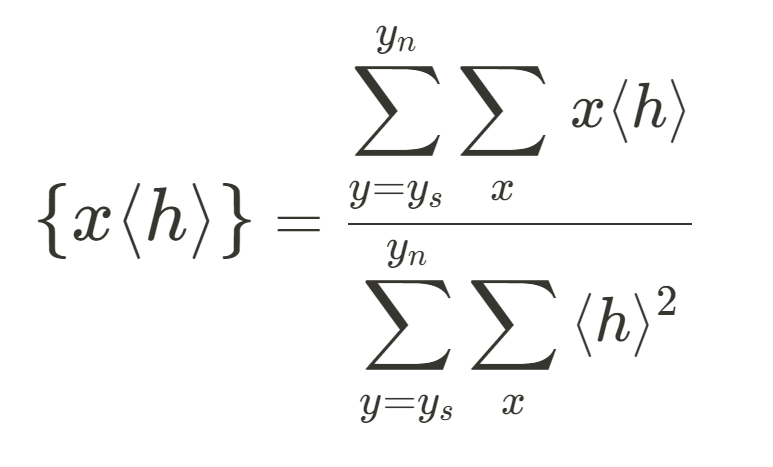
</p>

## Define budget calculation function

In [ ]:
def calculate_budget(field_variable, budget_variable):
    budget = np.einsum(
        '...ji, ...ji -> ...',
        field_variable,
        budget_variable
    ) / np.einsum(
        '...ji, ...ji -> ...',
        budget_variable,
        budget_variable
    )
    return budget

## Growth Budgets

### MSE

#### Calculate budget

In [ ]:
south_bound = -90
north_bound = 90
south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

# Calculate the column MSE : <h> = <T> + <q>
column_MSE = np.copy(output_column_temperature + output_column_moisture)

# Calculate the MSE tendency directly from the variable
MSE_tendency = np.gradient(column_MSE, downsampled_timepoints, axis=0)

MSE_growth_budget = calculate_budget(
    MSE_tendency[:, south_lat_index:north_lat_index],
    column_MSE[:, south_lat_index:north_lat_index]
)

zonal_moistening_array = ZONAL_MOISTENING_PARAMETER * np.cos(output_zonal_gridpoints/EARTH_RADIUS)[None, None, :]

zonal_advection_growth_contribution = calculate_budget(
    zonal_moistening_array*output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)


# # Calculate the contribution of zonal advection : σ_x {u_1 <h>}
# zonal_advection_MSE_growth_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
#     output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
#     column_MSE[:, south_lat_index:north_lat_index, :]
# )

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
meridional_advection_MSE_growth_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    (
        ( # Quadratic base state σ_y * y * v_1
            output_meridional_gridpoints
            if mean_moisture_profile == 'quadratic' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Exponential base state σ_y * y * e^(-y^2) * v_1
            (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))
            if mean_moisture_profile == 'gaussian' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Offset gaussian base state σ_y * y * e^(-(y-δ)^2/σ^2) * v_1
            (
                (output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)*np.exp(
                    -((output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)/gaussian_length_scale)**2
                )
            )
            if mean_moisture_profile == 'asymmetric-gaussian' else np.ones_like(output_meridional_gridpoints)
        )
    )[None, south_lat_index:north_lat_index, None]
    *output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(np.copy(output_zonal_velocity), axis=2)
output_dudx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber),
    output_ux_fft
)
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(np.copy(output_meridional_velocity), axis=1)
output_dvdy_fft = np.einsum(
    'j, kji -> kji',
    (1j*meridional_wavenumber),
    output_vy_fft
)
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

moisture_stratification_structure = '-gaussian-y'
moisture_stratification_array = gross_moisture_stratification * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if moisture_stratification_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(
        output_meridional_gridpoints/METERS_PER_DEGREE, 
        -sensitivity_limit, 
        sensitivity_limit, 
        sensitivity_width, 
        1
    ))
        if  moisture_stratification_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
    * (
        np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2)
        if moisture_stratification_structure == '-gaussian-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_MSE_growth_contribution = (
    GROSS_DRY_STABILITY
    * calculate_budget(
        (GROSS_DRY_STABILITY - moisture_stratification_array)/GROSS_DRY_STABILITY*vertical_velocity[:, south_lat_index:north_lat_index, :], 
        column_MSE[:, south_lat_index:north_lat_index, :]
    )
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
# moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
#     (
#         np.exp(-(output_meridional_gridpoints/length_scale)**2)
#         if moisture_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
#     )
#     *(
#     (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
#         if  moisture_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
#     )
# )[None, :, None]

# temperature_sensitivity_array = TEMPERATURE_SENSITIVITY * (
#     (
#         np.exp(-(output_meridional_gridpoints/length_scale)**2)
#         if temperature_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
#     )
#     *(
#     (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
#         if  temperature_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
#     )
# )[None, :, None]

moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if moisture_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (
        1-fringe_region_damping_function(
            output_meridional_gridpoints/METERS_PER_DEGREE, 
            -sensitivity_limit, 
            sensitivity_limit, 
            sensitivity_width, 
            1
        )
    )
        if  moisture_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
    * (
        np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2)
        if moisture_sensitivity_structure == '-gaussian-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, :, None]

temperature_sensitivity_array = TEMPERATURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if temperature_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (
        1-fringe_region_damping_function(
            output_meridional_gridpoints/METERS_PER_DEGREE, 
            -sensitivity_limit, 
            sensitivity_limit, 
            sensitivity_width, 
            1
        )
    )
        if  temperature_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, :, None]

column_convective_heating = (
    moisture_sensitivity_array * output_column_moisture
    - temperature_sensitivity_array * output_column_temperature
) 

# Calculate column radiative heating <Q_r> = r<Q_c>
column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

# Calculate the contribution of column radiative heating : {<Q_r> <h>}
column_radiative_heating_MSE_growth_contribution = calculate_budget(
    column_radiative_heating[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)

#### # Calculate the contribution of diffusion : {𝒟∇^2(<h>)*<h>}
MSEx_fft = fft(column_MSE, axis=2)
MSEy_fft = fft(column_MSE, axis=1)

dMSEdx_dx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber)**2, 
    MSEx_fft 
)

dMSEdy_dy_fft = np.einsum(
    'j, kji -> kji',   
    (1j*meridional_wavenumber)**2,
    MSEy_fft
)

dMSEdx_dx = np.real(ifft(dMSEdx_dx_fft, axis=2))
dMSEdy_dy = np.real(ifft(dMSEdy_dy_fft, axis=1))

laplacian_MSE = dMSEdx_dx + dMSEdy_dy 
diffusion_MSE_growth_contribution = DIFFUSIVITY*calculate_budget(
    laplacian_MSE[:, south_lat_index:north_lat_index, :],
    column_MSE[:, south_lat_index:north_lat_index, :]
)

#### Residual
residual_MSE_growth = MSE_growth_budget - (
    vertical_advection_MSE_growth_contribution
    + zonal_advection_MSE_growth_contribution
    + meridional_advection_MSE_growth_contribution
    + column_radiative_heating_MSE_growth_contribution
    + diffusion_MSE_growth_contribution
)

MSE_growth_budget_dataset = xr.Dataset(
    data_vars = {
        'growth' : (['time'], MSE_growth_budget),
        'omega'  : (['time'], vertical_advection_MSE_growth_contribution),
        'u'      : (['time'], zonal_advection_MSE_growth_contribution),
        'v'      : (['time'], meridional_advection_MSE_growth_contribution),
        'Qr'     : (['time'], column_radiative_heating_MSE_growth_contribution),
        'D'      : (['time'], diffusion_MSE_growth_contribution),
        'residual':(['time'], residual_MSE_growth),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

MSE_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{specified_initial_condition_name}_MSE-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + f".nc"
)
MSE_growth_budget_dataset.to_netcdf(MSE_growth_budget_filename)
print(f"MSE growth budget saved as:\n{MSE_growth_budget_filename}")

In [ ]:
# np.shape(vertical_advection_MSE_growth_contribution)
np.shape(vertical_advection_MSE_growth_contribution)

#### Plot budget

##### Single time

In [ ]:
# Load MSE_growth budget
loaded_MSE_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{specified_initial_condition_name}_MSE-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + f".nc"
)
loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)
print(f"MSE growth budget loaded from:\n{loaded_MSE_growth_budget_filename}")
print(f"========================================================")

# Specify the time at which to calculate/plot the budget
t = day_to_index(10)

# Label the bars 
# bar_labels = [
#     r'Growth',
#     r'ω$_1$mM$_s$',
#     r'σ$_x$u$_1$',
#     r'-σ$_y$yv$_1$', 
#     r'$\langle$Q$_r$$\rangle$',
#     # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
#     r'residual'
# ]

bar_labels = [
    "Growth",
    f"Vertical \nadvection" ,
    f"Zonal \nadvection",
    f"Meridional \nadvection",
    f"Column \nradiative \nheating",
    # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
    r'residual'
]

grand_max = []
for variable in loaded_MSE_growth_budget.data_vars:
    grand_max.append(np.abs(SECONDS_PER_DAY*loaded_MSE_growth_budget[variable][t]))
grand_max = np.max(grand_max)

bar_values = [
    SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][t],   
    SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'][t], 
    SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][t], 
    SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][t], 
    SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][t],
    # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][t],
    SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][t],
]

bar_colors = [
    '#ffa500', 
    '#1cf91a',
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c', 
    # 'red', 
    '#bcbcbc'
]

bar_positions = np.arange(len(bar_values))

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
# plt.title(
#     f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.0f}, " 
#     + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
#     pad=10
# )
bar_container = plt.bar(bar_positions, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)

# plt.ylim(-0.2, 0.2)
plt.ylim(-1.05*round_out(grand_max, 'hundredths'), 1.05*round_out(grand_max, 'hundredths'))
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.xticks(ticks=bar_positions, labels=bar_labels, rotation=0, fontsize=22)
plt.ylabel(r'day$^{-1}$', labelpad=35, rotation=0, va='center')
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_MSE_growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

In [ ]:
# Load MSE_growth budget
loaded_MSE_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{specified_initial_condition_name}_MSE-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + f".nc"
)
loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)
print(f"MSE growth budget loaded from:\n{loaded_MSE_growth_budget_filename}")
print(f"========================================================")

# Specify the time at which to calculate/plot the budget
t = day_to_index(360)

# Label the bars 
bar_labels = [
    r'Growth',
    r'ω$_1$mM$_s$ + $\langle$Q$_r$$\rangle$',
    # 'Column Processes',
    r'σ$_x$u$_1$',
    r'-σ$_y$yv$_1$', 
    # r'$\langle$Q$_r$$\rangle$',
    # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
    r'residual'
]

bar_values = [
    SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][t],   
    SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'][t] + SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][t], 
    SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][t], 
    SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][t], 
    
    # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][t],
    SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][t],
]

bar_colors = [
    '#ffa500', 
    '#1cf91a',
    '#0533ff', 
    '#ff40ff', 
    # '#4e2d8c', 
    # 'red', 
    '#bcbcbc'
]

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(
    f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.0f}, " 
    + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
    pad=10
)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.ylabel(r'day$^{-1}$', labelpad=35, rotation=0, va='center')
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_MSE_growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

##### Multiple times

In [ ]:
# Load MSE_growth budget
loaded_MSE_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{specified_initial_condition_name}_MSE-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + f".nc"
)
loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)
print(f"MSE growth budget loaded from:\n{loaded_MSE_growth_budget_filename}")
print(f"========================================================")

# Specify the time at which to calculate/plot the budget
# t = day_to_index(360)

# Label the bars 
bar_labels = [
    r'Growth',
    r'ω$_1$mM$_s$',
    # r'ω$_1$mM$_s$ + $\langle$Q$_r$$\rangle$',
    # 'Column Processes',
    r'σ$_x$u$_1$',
    r'-σ$_y$yv$_1$', 
    r'$\langle$Q$_r$$\rangle$',
    # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
    r'residual'
]

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
fig = plt.figure(figsize=(16.5, 22))
gs_main = gs.GridSpec(4, 1, figure=fig)
gs_main.update(bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.25)

ax = []
ax.append(fig.add_subplot(gs_main[0]))
ax.append(fig.add_subplot(gs_main[1]))
ax.append(fig.add_subplot(gs_main[2]))
ax.append(fig.add_subplot(gs_main[3]))

for index, t in enumerate([day_to_index(10), day_to_index(120), day_to_index(240), day_to_index(360)]):
    ax[index].set_title(
        f"Day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.0f}", 
        pad=10,
        fontsize=20
    )
    
    bar_values = [
        SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][t],   
        SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'][t], 
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'][t] + SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][t], 
        SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][t], 
        SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][t], 
        SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][t],
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][t],
    ]
    
    bar_colors = [
        '#ffa500', 
        '#1cf91a',
        '#0533ff', 
        '#ff40ff', 
        '#4e2d8c', 
        # 'red', 
        '#bcbcbc'
    ]
    ax[index].bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
    ax[index].axhline(y=0, color='gray', lw=3, alpha=0.75)
    ax[index].set_ylabel(r'day$^{-1}$', labelpad=35, rotation=0, va='center')
    # ax[index].set_ylim(-0.1, 0.1)
    ax[index].set_ylim(-0.25, 0.25)
    ax[index].set_aspect('auto')
    
    
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_MSE_growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

##### Animation

All processes view

In [ ]:
south_bound = 0
north_bound = 90

# Load MSE_growth budget
loaded_MSE_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{specified_initial_condition_name}_MSE-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + f".nc"
)
loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)
print(f"MSE growth budget loaded from:\n{loaded_MSE_growth_budget_filename}")
print(f"========================================================")

starting_frame = day_to_index(2)
ending_frame = day_to_index(360)
frame_interval = day_to_index(2)

bar_labels = [
    r'Growth',
    r'ω$_1$mM$_s$',
    r'σ$_x$u$_1$',
    r'-σ$_y$yv$_1$', 
    r'$\langle$Q$_r$$\rangle$',
    # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
    r'residual'
]
bar_colors = [
    '#ffa500', 
    '#1cf91a', 
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c', 
    # 'red', 
    '#bcbcbc'
]

grand_max = np.max(
    (
        SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][starting_frame:ending_frame],
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][starting_frame:ending_frame],
    )
)

grand_min = np.min(
    (
        SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][starting_frame:ending_frame],
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][starting_frame:ending_frame],
    )
)

plt.style.use('default')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.4))

def update(t):
    bar_values = [
        SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][t],
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][t],
        ]

    ax.clear()
    ax.set_title(
        f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.0f}, " 
        + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
        pad=10
)
    ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
    ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
    ax.set_ylabel(r'day$^{-1}$', labelpad=20, rotation=0, va='center')
    # ax.set_ylim(1.1*round_out(grand_min, 'tenths'), 1.1*round_out(grand_max, 'tenths'))
    # ax.set_ylim(grand_min-0.05, grand_max+0.05)
    ax.set_ylim(-0.225, 0.225)

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}"
    + f"_MSE-growth-budget_animation"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".mp4", 
    dpi=200
)

Column Process view

In [ ]:
# Load MSE_growth budget
loaded_MSE_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{specified_initial_condition_name}_MSE-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + f".nc"
)
loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)
print(f"MSE growth budget loaded from:\n{loaded_MSE_growth_budget_filename}")
print(f"========================================================")

starting_frame = day_to_index(5)
ending_frame = day_to_index(360)
frame_interval = day_to_index(5)

bar_labels = [
    r'Growth',
    # r'ω$_1$mM$_s$',
    r'ω$_1$mM$_s$ + $\langle$Q$_r$$\rangle$',
    r'σ$_x$u$_1$',
    r'-σ$_y$yv$_1$', 
    # r'$\langle$Q$_r$$\rangle$',
    # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
    r'residual'
]
bar_colors = [
    '#ffa500', 
    '#1cf91a', 
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c', 
    # 'red', 
    '#bcbcbc'
]

grand_max = np.max(
    (
        SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][starting_frame:ending_frame],
        SECONDS_PER_DAY*(loaded_MSE_growth_budget['omega'][starting_frame:ending_frame]+loaded_MSE_growth_budget['Qr'][starting_frame:ending_frame]),
        SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][starting_frame:ending_frame],
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][starting_frame:ending_frame],
    )
)

grand_min = np.min(
    (
        SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][starting_frame:ending_frame],
        SECONDS_PER_DAY*(loaded_MSE_growth_budget['omega'][starting_frame:ending_frame]+loaded_MSE_growth_budget['Qr'][starting_frame:ending_frame]),
        SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][starting_frame:ending_frame],
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][starting_frame:ending_frame],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][starting_frame:ending_frame],
    )
)

plt.style.use('default')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.4))

def update(t):
    bar_values = [
        SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][t],
        SECONDS_PER_DAY*(loaded_MSE_growth_budget['omega'][t]+loaded_MSE_growth_budget['Qr'][t]),
        SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][t],
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][t],
        ]

    ax.clear()
    ax.set_title(
        f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.0f}, " 
        + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
        pad=10
)
    ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
    ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
    ax.set_ylabel(r'day$^{-1}$', labelpad=20, rotation=0, va='center')
    ax.set_ylim(1.1*round_out(grand_min, 'tenths'), 1.1*round_out(grand_max, 'tenths'))

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}"
    + f"_MSE-growth-budget_animation_column-process-view"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".mp4", 
    dpi=200
)

### Multiple regions

#### Single time

In [ ]:
# Specify regions to plot
regions = [(-90, 0), (0, 90), (-90, 90)]

# Label the bars 
bar_labels = [
    "Growth",
    # f"Vertical \nadvection" ,
    f"Column \nprocesses",
    f"Zonal \nadvection",
    f"Meridional \nadvection",
    # f"Column \nradiative heating",
    r'residual'
]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

width = 0.25
multiplier = 0
x = np.arange(len(bar_labels))

t = day_to_index(360)

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
bar_max = []
for region in regions:

    south_bound = region[0]
    north_bound = region[1]
    loaded_MSE_growth_budget_filename = (
        f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
        + f"{specified_initial_condition_name}_MSE-growth-budget"
        + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
        + f".nc"
    )
    loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)

    offset = width * multiplier
    bar_values = [
        SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'].isel(time=t).values,  
        (SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'].isel(time=t).values + SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'].isel(time=t).values),
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'].isel(time=t).values, 
        SECONDS_PER_DAY*loaded_MSE_growth_budget['u'].isel(time=t).values, 
        SECONDS_PER_DAY*loaded_MSE_growth_budget['v'].isel(time=t).values, 
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'].isel(time=t).values,
        # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][t],
        SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'].isel(time=t).values,
    ]
    bar_max.append(np.max(bar_values))

    rects = ax.bar(
        x + offset, 
        bar_values, 
        label = bar_labels, 
        color = bar_colors, 
        width = width,
        edgecolor='gray', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

for l in range(len(bar_labels)):
    # ax.text(l+2.5*offset/5, 1.05*np.max(bar_max), s=bar_labels[l], ha='center')
    ax.text(l+2.5*offset/5, 0.110, s=bar_labels[l], ha='center')

ax.axhline(y = 0, color='gray', lw=2)
ax.set_ylim(-0.1, 0.1)

ax.set_xticks(
    np.concatenate((x, x+offset/2, x+offset)),
    # sorted(np.arange(len(bar_labels)*len(regions))%len(regions)+1)
    np.concatenate((
        np.tile(np.array(['SH'], dtype='str'), len(bar_labels)), 
        np.tile(np.array(['NH'], dtype='str'), len(bar_labels)),
        np.tile(np.array(['All'], dtype='str'), len(bar_labels)),
    ))
)
ax.set_ylabel(r'day$^{-1}$', rotation=0, labelpad=20)
ax.set_xlabel('Region', labelpad=10)
# ax.legend()
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{initial_condition_type}-initial-condition_multi-scale_growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"    
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

#### Animation

In [ ]:
# starting_frame = day_to_index(5)
# ending_frame = day_to_index(360)
# frame_interval = day_to_index(5)

# # Specify regions to plot
# regions = [(-90, 0), (0, 90), (-90, 90)]

# # Label the bars 
# bar_labels = [
#     "Growth",
#     f"Vertical \nadvection" ,
#     # f"Column \nprocesses",
#     f"Zonal \nadvection",
#     f"Meridional \nadvection",
#     f"Column \nradiative heating",
#     r'residual'
# ]
# bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

# plt.style.use('default')
# plt.rcParams.update({'font.size':18})
# [fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))

# width = 0.25
# multiplier = 0
# x = np.arange(len(bar_labels))

# bar_max = []
# for region in regions:

#     south_bound = region[0]
#     north_bound = region[1]
#     loaded_MSE_growth_budget_filename = (
#         f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
#         + f"{specified_initial_condition_name}_MSE-growth-budget"
#         + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#         + f".nc"
#     )
#     loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)

#     offset = width * multiplier
#     bar_values = [
#         SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'].isel(time=starting_frame).values,   
#         SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'].isel(time=starting_frame).values, 
#         SECONDS_PER_DAY*loaded_MSE_growth_budget['u'].isel(time=starting_frame).values, 
#         SECONDS_PER_DAY*loaded_MSE_growth_budget['v'].isel(time=starting_frame).values, 
#         SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'].isel(time=starting_frame).values,
#         # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][t],
#         SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'].isel(time=starting_frame).values,
#     ]
#     bar_max.append(np.max(bar_values))

#     ax.clear()
    
#     rects = ax.bar(
#         x + offset, 
#         bar_values, 
#         label = bar_labels, 
#         color = bar_colors, 
#         width = width,
#         edgecolor='gray', 
#         linewidth=3,
#         align='center'
#     )    
#     # ax.bar_label(rects, padding=0.3)
#     multiplier += 1

# for l in range(len(bar_labels)):
#     ax.text(l+2.5*offset/5, 1.175*np.max(bar_max), s=bar_labels[l], ha='center')

# ax.axhline(y = 0, color='gray', lw=2)

# ax.set_xticks(
#     np.concatenate((x, x+offset/2, x+offset)),
#     # sorted(np.arange(len(bar_labels)*len(regions))%len(regions)+1)
#     np.concatenate((
#         np.tile(np.array(['SH'], dtype='str'), len(bar_labels)), 
#         np.tile(np.array(['NH'], dtype='str'), len(bar_labels)),
#         np.tile(np.array(['All'], dtype='str'), len(bar_labels)),
#     ))
# )
# ax.set_ylabel(r'day$^{-1}$', rotation=0, labelpad=20)
# ax.set_xlabel('Region', labelpad=10)

# def update(t):
#     width = 0.25
#     multiplier = 0
#     x = np.arange(len(bar_labels))
    
#     bar_max = []
#     for region in regions:
    
#         south_bound = region[0]
#         north_bound = region[1]
#         loaded_MSE_growth_budget_filename = (
#             f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
#             + f"{specified_initial_condition_name}_MSE-growth-budget"
#             + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#             + f".nc"
#         )
#         loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)
    
#         offset = width * multiplier
#         bar_values = [
#             SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'].isel(time=t).values,   
#             SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'].isel(time=t).values, 
#             SECONDS_PER_DAY*loaded_MSE_growth_budget['u'].isel(time=t).values, 
#             SECONDS_PER_DAY*loaded_MSE_growth_budget['v'].isel(time=t).values, 
#             SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'].isel(time=t).values,
#             # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][t],
#             SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'].isel(time=t).values,
#         ]
#         bar_max.append(np.max(bar_values))

#         ax.clear()
        
#         rects = ax.bar(
#             x + offset, 
#             bar_values, 
#             label = bar_labels, 
#             color = bar_colors, 
#             width = width,
#             edgecolor='gray', 
#             linewidth=3,
#             align='center'
#         )    
#         # ax.bar_label(rects, padding=0.3)
#         multiplier += 1

#         ax.axhline(y = 0, color='gray', lw=2)
        
#         ax.set_xticks(
#             np.concatenate((x, x+offset/2, x+offset)),
#             # sorted(np.arange(len(bar_labels)*len(regions))%len(regions)+1)
#             np.concatenate((
#                 np.tile(np.array(['SH'], dtype='str'), len(bar_labels)), 
#                 np.tile(np.array(['NH'], dtype='str'), len(bar_labels)),
#                 np.tile(np.array(['All'], dtype='str'), len(bar_labels)),
#             ))
#         )
#         ax.set_ylabel(r'day$^{-1}$', rotation=0, labelpad=20)
#         ax.set_xlabel('Region', labelpad=10)

# # for l in range(len(bar_labels)):
# #     ax.text(l+2.5*offset/5, 1.175*np.max(bar_max), s=bar_labels[l], ha='center')
        

# # Run the animation
# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=tqdm(
#         np.arange(starting_frame+1, ending_frame, frame_interval), 
#         ncols=100, 
#         position=0, 
#         leave=True
#     ), interval=300
# )

# anim.save(
#     f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}"
#     + f"_MSE-growth-budget_animation_multiple-regions-view"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".mp4", 
#     dpi=200
# )


### Moisture

#### Calculate budget

In [ ]:
south_bound = -90
north_bound = 90
south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

# Calculate the moisture tendency directly from the variable
moisture_tendency = np.gradient(output_column_moisture, downsampled_timepoints, axis=0)

moisture_growth_budget = calculate_budget(
    moisture_tendency[:, south_lat_index:north_lat_index],
    output_column_moisture[:, south_lat_index:north_lat_index]
)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_moisture_growth_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    output_column_moisture[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
meridional_advection_moisture_growth_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    (
        ( # Quadratic base state σ_y * y * v_1
            output_meridional_gridpoints
            if mean_moisture_profile == 'quadratic' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Exponential base state σ_y * y * e^(-y^2) * v_1
            (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))
            if mean_moisture_profile == 'gaussian' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Offset gaussian base state σ_y * y * e^(-(y-δ)^2/σ^2) * v_1
            (
                (output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)*np.exp(
                    -((output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)/gaussian_length_scale)**2
                )
            )
            if mean_moisture_profile == 'asymmetric-gaussian' else np.ones_like(output_meridional_gridpoints)
        )
    )[None, south_lat_index:north_lat_index, None]
    *output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
    output_column_moisture[:, south_lat_index:north_lat_index, :]
)

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(np.copy(output_zonal_velocity), axis=2)
output_dudx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber),
    output_ux_fft
)
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(np.copy(output_meridional_velocity), axis=1)
output_dvdy_fft = np.einsum(
    'j, kji -> kji',
    (1j*meridional_wavenumber),
    output_vy_fft
)
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_moisture_growth_contribution = -(
    gross_moisture_stratification
    * calculate_budget(
        vertical_velocity[:, south_lat_index:north_lat_index, :], 
        output_column_moisture[:, south_lat_index:north_lat_index, :]
    )
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if moisture_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  moisture_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

temperature_sensitivity_array = TEMPERATURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if temperature_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  temperature_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

column_convective_heating = (
    moisture_sensitivity_array * output_column_moisture
    - temperature_sensitivity_array * output_column_temperature
) 

# # Calculate column radiative heating <Q_r> = r<Q_c>
# column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

# Calculate the contribution of column convective heating
column_convective_heating_moisture_growth_contribution = -calculate_budget(
    column_convective_heating[:, south_lat_index:north_lat_index, :], 
    output_column_moisture[:, south_lat_index:north_lat_index, :]
)


#### Residual
residual_moisture_growth = moisture_growth_budget - (
    vertical_advection_moisture_growth_contribution
    + zonal_advection_moisture_growth_contribution
    + meridional_advection_moisture_growth_contribution
    + column_convective_heating_moisture_growth_contribution
    # + diffusion_growth_contribution
)

moisture_growth_budget_dataset = xr.Dataset(
    data_vars = {
        'growth' : (['time'], moisture_growth_budget),
        'omega'  : (['time'], vertical_advection_moisture_growth_contribution),
        'u'      : (['time'], zonal_advection_moisture_growth_contribution),
        'v'      : (['time'], meridional_advection_moisture_growth_contribution),
        'Qc'     : (['time'], column_convective_heating_moisture_growth_contribution),
        'residual':(['time'], residual_moisture_growth),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

moisture_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_moisture-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
moisture_growth_budget_dataset.to_netcdf(moisture_growth_budget_filename)
print(f"Moisture growth budget saved as:\n{moisture_growth_budget_filename}")
print(f"{'':{'='}^{50}}")

#### Plot budget

In [ ]:
# Load growth budget
loaded_moisture_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_moisture-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
loaded_moisture_growth_budget = xr.load_dataset(loaded_moisture_growth_budget_filename)
print(f"Moisture growth budget loaded from:\n{loaded_moisture_growth_budget_filename}")
print(f"{'':{'='}^{50}}")

# Specify the time at which to calculate/plot the budget
t = day_to_index(360)

# Label the bars 
bar_labels = [
    r'Growth',
    r'-M$_q$ω$_1$',
    r'σ$_x$u$_1$',
    r'-σ$_y$yv$_1$', 
    r'-$\langle$Q$_c$$\rangle$', 
    r'residual'
]

bar_values = [
    SECONDS_PER_DAY*loaded_moisture_growth_budget['growth'][t],   
    SECONDS_PER_DAY*loaded_moisture_growth_budget['omega'][t], 
    SECONDS_PER_DAY*loaded_moisture_growth_budget['u'][t], 
    SECONDS_PER_DAY*loaded_moisture_growth_budget['v'][t], 
    SECONDS_PER_DAY*loaded_moisture_growth_budget['Qc'][t],
    SECONDS_PER_DAY*loaded_moisture_growth_budget['residual'][t],
]

bar_colors = [
    '#ffa500', 
    '#1cf91a',
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c', 
    '#bcbcbc'
]

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(
    f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}, " 
    + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
    pad=10
)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.ylabel(r'day$^{-1}$', labelpad=35, rotation=0, va='center')
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_moisture-growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

### Convective Heating

### Calculate budget

In [ ]:
south_bound = -90
north_bound = 90
south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if moisture_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  moisture_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

temperature_sensitivity_array = TEMPERATURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if temperature_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  temperature_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

column_convective_heating = (
    moisture_sensitivity_array * output_column_moisture[:, south_lat_index:north_lat_index, :]
    - temperature_sensitivity_array * output_column_temperature[:, south_lat_index:north_lat_index, :]
) 

column_convective_heating_tendency = np.gradient(column_convective_heating, downsampled_timepoints, axis=0)


convective_heating_growth_budget = calculate_budget(
    column_convective_heating_tendency[:, south_lat_index:north_lat_index],
    column_convective_heating[:, south_lat_index:north_lat_index]
)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_convective_heating_growth_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    moisture_sensitivity_array*output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    column_convective_heating[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
meridional_advection_convective_heating_growth_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    (
        ( # Quadratic base state σ_y * y * v_1
            output_meridional_gridpoints
            if mean_moisture_profile == 'quadratic' else np.ones_like(output_meridional_gridpoints)
        )
        *( # Exponential base state σ_y * y * e^(-y^2) * v_1
            (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))
            if mean_moisture_profile == 'gaussian' else np.ones_like(output_meridional_gridpoints)
        )
        # * ( # Offset gaussian base state σ_y * y * e^(-(y-δ)^2/σ^2) * v_1
        #     (
        #         (output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)*np.exp(
        #             -((output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)/gaussian_length_scale)**2
        #         )
        #     )
        #     if mean_moisture_profile == 'asymmetric-gaussian' else np.ones_like(output_meridional_gridpoints)
        # )
    )[None, south_lat_index:north_lat_index, None]
    * moisture_sensitivity_array * output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
    column_convective_heating[:, south_lat_index:north_lat_index, :]
)

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(np.copy(output_zonal_velocity), axis=2)
output_dudx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber),
    output_ux_fft
)
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(np.copy(output_meridional_velocity), axis=1)
output_dvdy_fft = np.einsum(
    'j, kji -> kji',
    (1j*meridional_wavenumber),
    output_vy_fft
)
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_convective_heating_growth_contribution = -(
    calculate_budget(
        (moisture_sensitivity_array*gross_moisture_stratification + temperature_sensitivity_array*GROSS_DRY_STABILITY)*vertical_velocity[:, south_lat_index:north_lat_index, :], 
        column_convective_heating[:, south_lat_index:north_lat_index, :]
    )
)

effective_sensitivity = moisture_sensitivity_array + temperature_sensitivity_array*(1+CLOUD_RADIATIVE_PARAMETER)

moisture_convective_heating_growth_contribution = -(
    calculate_budget(
        moisture_sensitivity_array*effective_sensitivity*output_column_moisture[:, south_lat_index:north_lat_index, :], 
        column_convective_heating[:, south_lat_index:north_lat_index, :]
    )
)

temperature_convective_heating_growth_contribution = (
    calculate_budget(
        temperature_sensitivity_array*effective_sensitivity*output_column_temperature[:, south_lat_index:north_lat_index, :], 
        column_convective_heating[:, south_lat_index:north_lat_index, :]
    )
)

#### Residual
residual_convective_heating_growth = convective_heating_growth_budget - (
    vertical_advection_convective_heating_growth_contribution
    + zonal_advection_convective_heating_growth_contribution
    + meridional_advection_convective_heating_growth_contribution
    + moisture_convective_heating_growth_contribution
    + temperature_convective_heating_growth_contribution
    # + diffusion_growth_contribution
)

convective_heating_growth_budget_dataset = xr.Dataset(
    data_vars = {
        'growth' : (['time'], convective_heating_growth_budget),
        'omega'  : (['time'], vertical_advection_convective_heating_growth_contribution),
        'u'      : (['time'], zonal_advection_convective_heating_growth_contribution),
        'v'      : (['time'], meridional_advection_convective_heating_growth_contribution),
        'q'      : (['time'], moisture_convective_heating_growth_contribution),
        'T'      : (['time'], temperature_convective_heating_growth_contribution),
        'residual':(['time'], residual_convective_heating_growth),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

convective_heating_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_convective-heating-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
convective_heating_growth_budget_dataset.to_netcdf(convective_heating_growth_budget_filename)
print(f"Convective heating growth budget saved as:\n{convective_heating_growth_budget_filename}")
print(f"{'':{'='}^{50}}")

#### Plot budget

In [ ]:
# Load growth budget
loaded_convective_heating_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_convective-heating-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
loaded_convective_heating_growth_budget = xr.load_dataset(loaded_convective_heating_growth_budget_filename)
print(f"Convective heating growth budget loaded from:\n{loaded_convective_heating_growth_budget_filename}")
print(f"{'':{'='}^{50}}")

# Specify the time at which to calculate/plot the budget
t = day_to_index(360)

# Label the bars 
bar_labels = [
    r'Growth',
    r'-($\varepsilon_q$M$_q$+$\varepsilon_t$M$_s$)ω$_1$',
    r'$\varepsilon_q$σ$_x$u$_1$',
    r'-$\varepsilon_q$σ$_y$yv$_1$', 
    r'-$\varepsilon_q$$\varepsilon_a$$\langle$q$\rangle$', 
    r'$\varepsilon_q$$\varepsilon_a$$\langle$T$\rangle$', 
    r'residual'
]

bar_values = [
    SECONDS_PER_DAY*loaded_convective_heating_growth_budget['growth'][t],   
    SECONDS_PER_DAY*loaded_convective_heating_growth_budget['omega'][t], 
    SECONDS_PER_DAY*loaded_convective_heating_growth_budget['u'][t], 
    SECONDS_PER_DAY*loaded_convective_heating_growth_budget['v'][t], 
    SECONDS_PER_DAY*loaded_convective_heating_growth_budget['q'][t],
    SECONDS_PER_DAY*loaded_convective_heating_growth_budget['T'][t],
    SECONDS_PER_DAY*loaded_convective_heating_growth_budget['residual'][t],
]

bar_colors = [
    '#ffa500', 
    '#1cf91a',
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c',
    '#03f4fc',
    '#bcbcbc'
]

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(
    f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}, " 
    + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
    pad=10
)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.ylabel(r'day$^{-1}$', labelpad=35, rotation=0, va='center')
# plt.gca().set_xticklabels(fontsize=14)
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_convective-heating-growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

## Propagation Budgets

### MSE

#### Calculate budget

In [ ]:
# south_bound = -10
# north_bound = 10
south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

# Calculate the column MSE : <h> = <T> + <q>
column_MSE = np.copy(output_column_temperature + output_column_moisture)

# Calculate the MSE tendency directly from the variable
MSE_tendency = np.gradient(column_MSE, downsampled_timepoints, axis=0)

MSE_propagation_budget = calculate_budget(
    MSE_tendency[:, south_lat_index:north_lat_index, :],
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_MSE_propagation_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
meridional_advection_MSE_propagation_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    (
        ( # Quadratic base state σ_y * y * v_1
            output_meridional_gridpoints
            if mean_moisture_profile == 'quadratic' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Gaussian base state σ_y * y * e^(-y^2/σ^2) * v_1
            (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))
            if mean_moisture_profile == 'gaussian' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Offset gaussian base state σ_y * y * e^(-(y-δ)^2/σ^2) * v_1
            (
                (output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)*np.exp(
                    -((output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)/gaussian_length_scale)**2
                )
            )
            if mean_moisture_profile == 'asymmetric-gaussian' else np.ones_like(output_meridional_gridpoints)
        )
    )[None, south_lat_index:north_lat_index, None]
    * output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(output_zonal_velocity, axis=2)
output_dudx_fft = 1j*zonal_wavenumber[None,:]*output_ux_fft
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(output_meridional_velocity, axis=1)
output_dvdy_fft = 1j*meridional_wavenumber[:,None]*output_vy_fft
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_MSE_propagation_contribution = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * calculate_budget(
        vertical_velocity[:, south_lat_index:north_lat_index, :], 
        MSE_tendency[:, south_lat_index:north_lat_index, :]
    )
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if moisture_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  moisture_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, :, None]

temperature_sensitivity_array = TEMPERATURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if temperature_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  temperature_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, :, None]

column_convective_heating = (
    moisture_sensitivity_array * output_column_moisture
    - temperature_sensitivity_array * output_column_temperature
) 
    
# Calculate column radiative heating <Q_r> = r<Q_c>
column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

# Calculate the contribution of column radiative heating : {<Q_r> <h>}
column_radiative_heating_MSE_propagation_contribution = calculate_budget(
    column_radiative_heating[:, south_lat_index:north_lat_index, :],
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

#### # Calculate the contribution of diffusion : {𝒟∇^2<h> <h>}
MSEx_fft = fft(column_MSE, axis=2)
MSEy_fft = fft(column_MSE, axis=1)

dMSEdx_dx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber)**2, 
    MSEx_fft 
)

dMSEdy_dy_fft = np.einsum(
    'j, kji -> kji',   
    (1j*meridional_wavenumber)**2,
    MSEy_fft
)

dMSEdx_dx = np.real(ifft(dMSEdx_dx_fft, axis=2))
dMSEdy_dy = np.real(ifft(dMSEdy_dy_fft, axis=1))

laplacian_MSE = dMSEdx_dx + dMSEdy_dy 
diffusion_MSE_propagation_contribution = DIFFUSIVITY*calculate_budget(
    laplacian_MSE[:, south_lat_index:north_lat_index, :],
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

#### Residual
residual_MSE_propagation = MSE_propagation_budget - (
    vertical_advection_MSE_propagation_contribution
    + zonal_advection_MSE_propagation_contribution
    + meridional_advection_MSE_propagation_contribution
    + column_radiative_heating_MSE_propagation_contribution
    + diffusion_MSE_propagation_contribution
)

MSE_propagation_budget_dataset = xr.Dataset(
    data_vars = {
        'propagation' : (['time'], MSE_propagation_budget),
        'omega'  : (['time'], vertical_advection_MSE_propagation_contribution),
        'u'      : (['time'], zonal_advection_MSE_propagation_contribution),
        'v'      : (['time'], meridional_advection_MSE_propagation_contribution),
        'Qr'     : (['time'], column_radiative_heating_MSE_propagation_contribution),
        'D'      : (['time'], diffusion_MSE_propagation_contribution),
        'residual':(['time'], residual_MSE_propagation),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

MSE_propagation_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/{specified_initial_condition_name}" 
    + f"_MSE-propagation-budget_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
MSE_propagation_budget_dataset.to_netcdf(MSE_propagation_budget_filename)
print(f"MSE propagation budget saved as:\n{MSE_propagation_budget_filename}")

#### Plot propagation budget

##### Single time

In [ ]:
# Load growth budget
loaded_MSE_propagation_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/{specified_initial_condition_name}" 
    + f"_MSE-propagation-budget_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
loaded_MSE_propagation_budget = xr.load_dataset(loaded_MSE_propagation_budget_filename)
print(f"MSE propagation budget loaded from:\n{loaded_MSE_propagation_budget_filename}")
print(f"========================================================")


# Specify the time at which to calculate/plot the MSE_propagation_contribution
t = day_to_index(360)

# Label the bars 
# bar_labels = [
#     r'Propagation',
#     r'ω$_1$mM$_s$',
#     r'σ$_x$u$_1$', 
#     r'-σ$_y$yv$_1$',
#     r'$\langle$Q$_r$$\rangle$',
#     # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$',
#     r'residual'
# ]

bar_labels = [
"Growth",
f"Vertical \nadvection" ,
f"Zonal \nadvection",
f"Meridional \nadvection",
f"Column \nradiative \nheating",
# r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
r'residual'
]

bar_positions = np.arange(len(bar_values))

bar_values = [
    loaded_MSE_propagation_budget['propagation'][t],
    loaded_MSE_propagation_budget['omega'][t],
    loaded_MSE_propagation_budget['u'][t],
    loaded_MSE_propagation_budget['v'][t],
    loaded_MSE_propagation_budget['Qr'][t],
    # loaded_MSE_propagation_budget['D'][t],
    loaded_MSE_propagation_budget['residual'][t],
]    

bar_colors = [
    '#ffa500',
    '#1cf91a',
    '#0533ff',
    '#ff40ff',
    '#4e2d8c',
    # 'red',
    '#bcbcbc'
]


# Plot the MSE_propagation budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))

# Plot the budgets
bar_container = plt.bar(bar_positions, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.ylim(-1.75, 1.75)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.xticks(ticks=bar_positions, labels=bar_labels, rotation=0, fontsize=22)
plt.show()

# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_MSE-propagation-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days" 
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

##### Joint growth-propagation plots

In [ ]:

south_bound = -90
north_bound = 90

# Load MSE_growth budget
loaded_MSE_growth_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{specified_initial_condition_name}_MSE-growth-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + f".nc"
)
loaded_MSE_growth_budget = xr.load_dataset(loaded_MSE_growth_budget_filename)
print(f"MSE growth budget loaded from:\n{loaded_MSE_growth_budget_filename}")
print(f"========================================================")

# Load growth budget
loaded_MSE_propagation_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/{specified_initial_condition_name}" 
    + f"_MSE-propagation-budget_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
loaded_MSE_propagation_budget = xr.load_dataset(loaded_MSE_propagation_budget_filename)
print(f"MSE propagation budget loaded from:\n{loaded_MSE_propagation_budget_filename}")
print(f"========================================================")


# Specify the time at which to calculate/plot the budget
t = day_to_index(360)

# Label the bars 
# bar_labels = [
#     r'Growth',
#     r'ω$_1$mM$_s$',
#     r'σ$_x$u$_1$',
#     r'-σ$_y$yv$_1$', 
#     r'$\langle$Q$_r$$\rangle$',
#     # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
#     r'residual'
# ]

growth_bar_labels = [
    "Growth",
    f"Vertical \nadvection" ,
    f"Zonal \nadvection",
    f"Meridional \nadvection",
    f"Column \nradiative \nheating",
    # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
    r'residual'
]

propagation_bar_labels = [
    "Propagation",
    f"Vertical \nadvection" ,
    f"Zonal \nadvection",
    f"Meridional \nadvection",
    f"Column \nradiative \nheating",
    # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
    r'residual'
]

bar_colors = [
    '#ffa500', 
    '#1cf91a',
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c', 
    # 'red', 
    '#bcbcbc'
]


growth_bar_values = [
    SECONDS_PER_DAY*loaded_MSE_growth_budget['growth'][t]/(2*np.pi),  
    SECONDS_PER_DAY*loaded_MSE_growth_budget['omega'][t]/(2*np.pi), 
    SECONDS_PER_DAY*loaded_MSE_growth_budget['u'][t]/(2*np.pi), 
    SECONDS_PER_DAY*loaded_MSE_growth_budget['v'][t]/(2*np.pi), 
    SECONDS_PER_DAY*loaded_MSE_growth_budget['Qr'][t]/(2*np.pi),
    # SECONDS_PER_DAY*loaded_MSE_growth_budget['D'][t],
    SECONDS_PER_DAY*loaded_MSE_growth_budget['residual'][t]/(2*np.pi),
]

bar_positions = np.arange(len(growth_bar_values))

propagation_bar_values = [
    loaded_MSE_propagation_budget['propagation'][t],
    loaded_MSE_propagation_budget['omega'][t],
    loaded_MSE_propagation_budget['u'][t],
    loaded_MSE_propagation_budget['v'][t],
    loaded_MSE_propagation_budget['Qr'][t],
    # loaded_MSE_propagation_budget['D'][t],
    loaded_MSE_propagation_budget['residual'][t],
]    


# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':20})
fig = plt.figure(figsize=(16.5, 8), dpi=500)
gs_main = gs.GridSpec(2, 1, figure=fig)
gs_main.update(bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.3)

ax = []
ax.append(fig.add_subplot(gs_main[0]))
ax.append(fig.add_subplot(gs_main[1]))

# Growth
# ax[0].set_title(f"Day {downsampled_timepoints[t]/SECONDS_PER_DAY:0.0f}", pad=15)
ax[0].bar(bar_positions, growth_bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
ax[0].axhline(y=0, color='gray', lw=3, alpha=0.75)
ax[0].set_xticks(ticks=bar_positions, labels=growth_bar_labels, rotation=0, fontsize=22)
ax[0].set_ylim(-0.22/(2*np.pi), 0.22/(2*np.pi))
ax[0].set_ylabel(r'day$^{-1}$', labelpad=35, rotation=0, va='center')
ax[0].tick_params(axis='x', length=8, width=3, color='gray', direction='in', pad=12)
ax[0].tick_params(axis='y', length=8, width=2, color='gray')
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[0].spines[axis].set_color("gray")
ax[0].text(x=-0.65, y=0.235/(2*np.pi), s='a)', color='k', fontsize=28)

# Propagation
ax[1].bar(bar_positions, propagation_bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
ax[1].axhline(y=0, color='gray', lw=3, alpha=0.75)
ax[1].set_xticks(ticks=bar_positions, labels=propagation_bar_labels, rotation=0, fontsize=22)
ax[1].set_ylim(-2.2, 2.2)
ax[1].tick_params(axis='x', length=8, width=3, color='gray', direction='in', pad=12)
ax[1].tick_params(axis='y', length=8, width=2, color='gray')
for axis in ['top','bottom','left','right']:
    ax[1].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_color("gray")
ax[1].text(x=-0.65, y=2.35, s='b)', color='k', fontsize=28)


plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_MSE_growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

##### Animation

In [ ]:
starting_frame = day_to_index(2)
ending_frame = day_to_index(300)
frame_interval = day_to_index(2)

# Load growth budget
loaded_MSE_propagation_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/{specified_initial_condition_name}" 
    + f"_MSE-propagation-budget_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
loaded_MSE_propagation_budget = xr.load_dataset(loaded_MSE_propagation_budget_filename)
print(f"MSE propagation budget loaded from:\n{loaded_MSE_propagation_budget_filename}")
print(f"========================================================")

grand_max = np.max(
    (
        loaded_MSE_propagation_budget['propagation'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['omega'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['u'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['v'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['Qr'][starting_frame:ending_frame],
        # loaded_MSE_propagation_budget['D'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['residual'][starting_frame:ending_frame],
    )
)
grand_min = np.min(
    (
        loaded_MSE_propagation_budget['propagation'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['omega'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['u'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['v'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['Qr'][starting_frame:ending_frame],
        # loaded_MSE_propagation_budget['D'][starting_frame:ending_frame],
        loaded_MSE_propagation_budget['residual'][starting_frame:ending_frame],
    )
)

bar_labels = [
    r'Propagation',
    r'ω$_1$mM$_s$',
    r'σ$_x$u$_1$',
    r'-σ$_y$yv$_1$', 
    r'$\langle$Q$_r$$\rangle$',
    # r'$\mathcal{D}\nabla^{2} \langle$h$\rangle$', 
    r'residual'
]
bar_colors = [
    '#ffa500',
    '#1cf91a',
    '#0533ff',
    '#ff40ff',
    '#4e2d8c',
    # 'red',
    '#bcbcbc'
]

plt.style.use('default')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.4))


def update(t):
    bar_values = [
        loaded_MSE_propagation_budget['propagation'][t],
        loaded_MSE_propagation_budget['omega'][t],
        loaded_MSE_propagation_budget['u'][t],
        loaded_MSE_propagation_budget['v'][t],
        loaded_MSE_propagation_budget['Qr'][t],
        # loaded_MSE_propagation_budget['D'][t],
        loaded_MSE_propagation_budget['residual'][t],
        ]

    plt.cla()
    ax.set_title(
        f"Propagation budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}, " 
        + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
        pad=10
)
    ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
    ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
    ax.set_ylabel(r'hr$^{-1}$', labelpad=20, rotation=0, va='center')
    ax.set_ylim(1.1*round_out(grand_min, 'tenths'), 1.1*round_out(grand_max, 'tenths'))

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}"
    + f"_MSE-propagation-budget_animation"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".mp4", 
    dpi=300
)

### Moisture

#### Calculate budget

In [ ]:
south_bound = -90
north_bound = 90
south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

# Calculate the moisture tendency directly from the variable
moisture_tendency = np.gradient(output_column_moisture, downsampled_timepoints, axis=0)

moisture_propagation_budget = calculate_budget(
    moisture_tendency[:, south_lat_index:north_lat_index],
    moisture_tendency[:, south_lat_index:north_lat_index]
)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_moisture_propagation_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    moisture_tendency[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
meridional_advection_moisture_propagation_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    (
        ( # Quadratic base state σ_y * y * v_1
            output_meridional_gridpoints
            if mean_moisture_profile == 'quadratic' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Exponential base state σ_y * y * e^(-y^2) * v_1
            (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))
            if mean_moisture_profile == 'gaussian' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Offset gaussian base state σ_y * y * e^(-(y-δ)^2/σ^2) * v_1
            (
                (output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)*np.exp(
                    -((output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)/gaussian_length_scale)**2
                )
            )
            if mean_moisture_profile == 'asymmetric-gaussian' else np.ones_like(output_meridional_gridpoints)
        )
    )[None, south_lat_index:north_lat_index, None]
    *output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
    moisture_tendency[:, south_lat_index:north_lat_index, :]
)

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(np.copy(output_zonal_velocity), axis=2)
output_dudx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber),
    output_ux_fft
)
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(np.copy(output_meridional_velocity), axis=1)
output_dvdy_fft = np.einsum(
    'j, kji -> kji',
    (1j*meridional_wavenumber),
    output_vy_fft
)
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_moisture_propagation_contribution = -(
    gross_moisture_stratification
    * calculate_budget(
        vertical_velocity[:, south_lat_index:north_lat_index, :], 
        moisture_tendency[:, south_lat_index:north_lat_index, :]
    )
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if moisture_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  moisture_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

temperature_sensitivity_array = TEMPERATURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if temperature_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  temperature_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

column_convective_heating = (
    moisture_sensitivity_array * output_column_moisture
    - temperature_sensitivity_array * output_column_temperature
) 

# # Calculate column radiative heating <Q_r> = r<Q_c>
# column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

# Calculate the contribution of column convective heating
column_convective_heating_moisture_propagation_contribution = -calculate_budget(
    column_convective_heating[:, south_lat_index:north_lat_index, :], 
    moisture_tendency[:, south_lat_index:north_lat_index, :]
)


#### Residual
residual_moisture_propagation = moisture_propagation_budget - (
    vertical_advection_moisture_propagation_contribution
    + zonal_advection_moisture_propagation_contribution
    + meridional_advection_moisture_propagation_contribution
    + column_convective_heating_moisture_propagation_contribution
    # + diffusion_propagation_contribution
)

moisture_propagation_budget_dataset = xr.Dataset(
    data_vars = {
        'propagation' : (['time'], moisture_propagation_budget),
        'omega'  : (['time'], vertical_advection_moisture_propagation_contribution),
        'u'      : (['time'], zonal_advection_moisture_propagation_contribution),
        'v'      : (['time'], meridional_advection_moisture_propagation_contribution),
        'Qc'     : (['time'], column_convective_heating_moisture_propagation_contribution),
        'residual':(['time'], residual_moisture_propagation),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

moisture_propagation_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_moisture-propagation-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
moisture_propagation_budget_dataset.to_netcdf(moisture_propagation_budget_filename)
print(f"Moisture propagation budget saved as:\n{moisture_propagation_budget_filename}")
print(f"{'':{'='}^{50}}")

#### Plot budget

In [ ]:
# Load propagation budget
loaded_moisture_propagation_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_moisture-propagation-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
loaded_moisture_propagation_budget = xr.load_dataset(loaded_moisture_propagation_budget_filename)
print(f"Moisture propagation budget loaded from:\n{loaded_moisture_propagation_budget_filename}")
print(f"{'':{'='}^{50}}")

# Specify the time at which to calculate/plot the budget
t = day_to_index(360)

# Label the bars 
bar_labels = [
    r'Propagation',
    r'-M$_q$ω$_1$',
    r'σ$_x$u$_1$',
    r'-σ$_y$yv$_1$', 
    r'-$\langle$Q$_c$$\rangle$', 
    r'residual'
]

bar_values = [
    loaded_moisture_propagation_budget['propagation'][t],   
    loaded_moisture_propagation_budget['omega'][t], 
    loaded_moisture_propagation_budget['u'][t], 
    loaded_moisture_propagation_budget['v'][t], 
    loaded_moisture_propagation_budget['Qc'][t],
    loaded_moisture_propagation_budget['residual'][t],
]

bar_colors = [
    '#ffa500', 
    '#1cf91a',
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c', 
    '#bcbcbc'
]

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(
    f"Moisture propagation budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}, " 
    + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
    pad=10
)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_moisture-propagation-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

### Convective Heating

#### Calculate budget

In [ ]:
south_bound = -90
north_bound = 90
south_lat_index = (
    np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
    if south_bound >= np.min(output_meridional_gridpoints)/METERS_PER_DEGREE else 0
)
north_lat_index = (
    1 + np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin() 
    if north_bound <= np.max(output_meridional_gridpoints)/METERS_PER_DEGREE else None
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if moisture_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  moisture_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

temperature_sensitivity_array = TEMPERATURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if temperature_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  temperature_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, south_lat_index:north_lat_index, None]

column_convective_heating = (
    moisture_sensitivity_array * output_column_moisture[:, south_lat_index:north_lat_index, :]
    - temperature_sensitivity_array * output_column_temperature[:, south_lat_index:north_lat_index, :]
) 

column_convective_heating_tendency = np.gradient(column_convective_heating, downsampled_timepoints, axis=0)


convective_heating_propagation_budget = calculate_budget(
    column_convective_heating_tendency[:, south_lat_index:north_lat_index],
    column_convective_heating_tendency[:, south_lat_index:north_lat_index]
)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_convective_heating_propagation_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    moisture_sensitivity_array*output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    column_convective_heating_tendency[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
meridional_advection_convective_heating_propagation_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    (
        ( # Quadratic base state σ_y * y * v_1
            output_meridional_gridpoints
            if mean_moisture_profile == 'quadratic' else np.ones_like(output_meridional_gridpoints)
        )
        *( # Exponential base state σ_y * y * e^(-y^2) * v_1
            (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))
            if mean_moisture_profile == 'gaussian' else np.ones_like(output_meridional_gridpoints)
        )
        # * ( # Offset gaussian base state σ_y * y * e^(-(y-δ)^2/σ^2) * v_1
        #     (
        #         (output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)*np.exp(
        #             -((output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)/gaussian_length_scale)**2
        #         )
        #     )
        #     if mean_moisture_profile == 'asymmetric-gaussian' else np.ones_like(output_meridional_gridpoints)
        # )
    )[None, south_lat_index:north_lat_index, None]
    * moisture_sensitivity_array * output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
    column_convective_heating_tendency[:, south_lat_index:north_lat_index, :]
)

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(np.copy(output_zonal_velocity), axis=2)
output_dudx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber),
    output_ux_fft
)
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(np.copy(output_meridional_velocity), axis=1)
output_dvdy_fft = np.einsum(
    'j, kji -> kji',
    (1j*meridional_wavenumber),
    output_vy_fft
)
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_convective_heating_propagation_contribution = -(
    calculate_budget(
        (moisture_sensitivity_array*gross_moisture_stratification + temperature_sensitivity_array*GROSS_DRY_STABILITY)*vertical_velocity[:, south_lat_index:north_lat_index, :], 
        column_convective_heating_tendency[:, south_lat_index:north_lat_index, :]
    )
)

effective_sensitivity = moisture_sensitivity_array + temperature_sensitivity_array*(1+CLOUD_RADIATIVE_PARAMETER)

moisture_convective_heating_propagation_contribution = -(
    calculate_budget(
        moisture_sensitivity_array*effective_sensitivity*output_column_moisture[:, south_lat_index:north_lat_index, :], 
        column_convective_heating_tendency[:, south_lat_index:north_lat_index, :]
    )
)

temperature_convective_heating_propagation_contribution = (
    calculate_budget(
        temperature_sensitivity_array*effective_sensitivity*output_column_temperature[:, south_lat_index:north_lat_index, :], 
        column_convective_heating_tendency[:, south_lat_index:north_lat_index, :]
    )
)

#### Residual
residual_convective_heating_propagation = convective_heating_propagation_budget - (
    vertical_advection_convective_heating_propagation_contribution
    + zonal_advection_convective_heating_propagation_contribution
    + meridional_advection_convective_heating_propagation_contribution
    + moisture_convective_heating_propagation_contribution
    + temperature_convective_heating_propagation_contribution
    # + diffusion_propagation_contribution
)

convective_heating_propagation_budget_dataset = xr.Dataset(
    data_vars = {
        'propagation' : (['time'], convective_heating_propagation_budget),
        'omega'  : (['time'], vertical_advection_convective_heating_propagation_contribution),
        'u'      : (['time'], zonal_advection_convective_heating_propagation_contribution),
        'v'      : (['time'], meridional_advection_convective_heating_propagation_contribution),
        'q'      : (['time'], moisture_convective_heating_propagation_contribution),
        'T'      : (['time'], temperature_convective_heating_propagation_contribution),
        'residual':(['time'], residual_convective_heating_propagation),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

convective_heating_propagation_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_convective-heating-propagation-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
convective_heating_propagation_budget_dataset.to_netcdf(convective_heating_propagation_budget_filename)
print(f"Convective heating propagation budget saved as:\n{convective_heating_propagation_budget_filename}")
print(f"{'':{'='}^{50}}")

#### Plot budget

In [ ]:
# Load propagation budget
loaded_convective_heating_propagation_budget_filename = (
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}_convective-heating-propagation-budget"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
)
loaded_convective_heating_propagation_budget = xr.load_dataset(loaded_convective_heating_propagation_budget_filename)
print(f"Convective heating propagation budget loaded from:\n{loaded_convective_heating_propagation_budget_filename}")
print(f"{'':{'='}^{50}}")

# Specify the time at which to calculate/plot the budget
t = day_to_index(360)

# Label the bars 
bar_labels = [
    r'Propagation',
    r'-($\varepsilon_q$M$_q$+$\varepsilon_t$M$_s$)ω$_1$',
    r'$\varepsilon_q$σ$_x$u$_1$',
    r'-$\varepsilon_q$σ$_y$yv$_1$', 
    r'-$\varepsilon_q$$\varepsilon_a$$\langle$q$\rangle$', 
    r'$\varepsilon_q$$\varepsilon_a$$\langle$T$\rangle$', 
    r'residual'
]

bar_values = [
    loaded_convective_heating_propagation_budget['propagation'][t],   
    loaded_convective_heating_propagation_budget['omega'][t], 
    loaded_convective_heating_propagation_budget['u'][t], 
    loaded_convective_heating_propagation_budget['v'][t], 
    loaded_convective_heating_propagation_budget['q'][t],
    loaded_convective_heating_propagation_budget['T'][t],
    loaded_convective_heating_propagation_budget['residual'][t],
]

bar_colors = [
    '#ffa500', 
    '#1cf91a',
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c',
    '#03f4fc',
    '#bcbcbc'
]

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(
    f"Propagation budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}, " 
    + f"{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}", 
    pad=10
)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
# plt.show()
plt.savefig(
      f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}_convective-heating-propagation-budget"
    + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
    + f"_{mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".png", 
    bbox_inches='tight'
)

## Horizontal structure of budget terms

### Calculate horizontal structure of advection fields

In [ ]:
print(f"Calculating advection fields...")
print(f"===============================")

# Calculate the column MSE : <h> = <T> + <q>
column_MSE = np.copy(output_column_temperature + output_column_moisture)

# Calculate the MSE tendency directly from the variable
MSE_tendency = np.gradient(column_MSE, downsampled_timepoints, axis=0)

#### Zonal advection field
zonal_moistening_array = ZONAL_MOISTENING_PARAMETER * np.cos(output_zonal_gridpoints/EARTH_RADIUS)[None, None, :]
zonal_advection_field = zonal_moistening_array*output_zonal_velocity

#### Meridional advection field
print(f"Mean Moisture Profile: {mean_moisture_profile}")
meridional_advection_field = -MERIDIONAL_MOISTENING_PARAMETER*(
    (
        ( # Quadratic base state σ_y * y * v_1
            output_meridional_gridpoints
            if mean_moisture_profile == 'quadratic' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Exponential base state σ_y * y * e^(-y^2) * v_1
            (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))
            if mean_moisture_profile == 'gaussian' else np.ones_like(output_meridional_gridpoints)
        )
        * ( # Offset gaussian base state σ_y * y * e^(-(y-δ)^2/σ^2) * v_1
            (
                (output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)*np.exp(
                    -((output_meridional_gridpoints-MERIDIONAL_OFFSET_PARAMETER)/gaussian_length_scale)**2
                )
            )
            if mean_moisture_profile == 'asymmetric-gaussian' else np.ones_like(output_meridional_gridpoints)
        )
    )[None, :, None]
    * output_meridional_velocity 
)

#### Vertical advection field
## Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(output_zonal_velocity, axis=2)
output_dudx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber),
    output_ux_fft
)
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(output_meridional_velocity, axis=1)
output_dvdy_fft = np.einsum(
    'j, kji -> kji',
    (1j*meridional_wavenumber),
    output_vy_fft
)
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

vertical_advection_field = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * vertical_velocity
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if moisture_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  moisture_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, :, None]

temperature_sensitivity_array = TEMPERATURE_SENSITIVITY * (
    (
        np.exp(-(output_meridional_gridpoints/length_scale)**2)
        if temperature_sensitivity_structure == '-exp-y' else np.ones_like(output_meridional_gridpoints)
    )
    *(
    (1-fringe_region_damping_function(output_meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))
        if  temperature_sensitivity_structure == '-step-y' else np.ones_like(output_meridional_gridpoints)
    )
)[None, :, None]

column_convective_heating = (
    moisture_sensitivity_array * output_column_moisture
    - temperature_sensitivity_array * output_column_temperature
) 

# Calculate column radiative heating <Q_r> = r<Q_c>
column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

print(f"===========================")
print(f"Advection fields calculated")

### Plot MSE structure and advection fields

#### Single time

##### Horizontal orientation

In [ ]:
bar_colors = [
    '#ffa500', 
    '#1cf91a',
    '#0533ff', 
    '#ff40ff', 
    '#4e2d8c', 
    'red', 
    '#bcbcbc'
]

plt.style.use('default')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize=(16.5, 6.5))
gs_main = gs.GridSpec(2, 1, height_ratios = [30,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.25)

gs_maps = gs.GridSpecFromSubplotSpec(1, 2, wspace=0.05, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(1, 30, subplot_spec=gs_main[1])

ax = []
ax.append(fig.add_subplot(gs_maps[0]))
ax.append(fig.add_subplot(gs_maps[1]))

cbar_ax = fig.add_subplot(gs_cbar[:, 1:-1])

t = day_to_index(30)
plt.suptitle(f"Day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.0f}", y=1.01, fontsize=20)

#### First plot
ax[0].set_title(r'(a) MSE, -σ$_y$yv$_1$, and σ$_x$u$_1$')
CF_MSE = ax[0].contourf(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    column_MSE[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_v = ax[0].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    meridional_advection_field[t],
    colors=bar_colors[3],
    # levels=np.delete(np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), [5])
)


CS_u = ax[0].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    zonal_advection_field[t],
    colors=bar_colors[2],
    levels=np.delete(np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), [5])
)

xlims = (-180/k, 180/k)
ylims = (-35, 35)
cbar = plt.colorbar(CF_MSE, cax=cbar_ax, orientation='horizontal')
cbar.set_label('K', rotation=0, va='center', labelpad=20)

# longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax[0].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
# Latitude
# latitude_ticks = np.arange(-90, 90+20, 20)
latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax[0].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
ax[1].set_yticklabels('')
ax[0].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
ax[0].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
ax[0].set_aspect('auto')


#### Second Plot
ax[1].set_title(r'(b) MSE, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
ax[1].contourf(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    column_MSE[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_Qr = ax[1].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    column_radiative_heating[t],
    colors=bar_colors[4],
    levels=np.delete(np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), [5])
)

CS_omega = ax[1].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    vertical_advection_field[t],
    colors=bar_colors[1],
    levels=np.delete(np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), [5])
)


# longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax[1].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
# Latitude
# latitude_ticks = np.arange(-90, 90+20, 20)
latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax[1].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
ax[1].set_yticklabels('')
ax[1].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
ax[1].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
ax[1].set_aspect('auto')

plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_MSE-structure"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

In [ ]:
day = day_to_index(360)
plt.figure(figsize=(16,6), dpi=500)
plt.contourf(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    meridional_advection_field[day]+zonal_advection_field[day],
    cmap='BrBG',
    norm=mcolors.CenteredNorm(vcenter=0)
)
plt.colorbar()

plt.contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    output_column_moisture[day],
    colors='k',
    norm=mcolors.CenteredNorm(vcenter=0)
)
plt.ylim(-31.1, 31.1)
plt.show()

In [ ]:
# south_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - 5).argmin()
# north_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - 20).argmin()

# t = day_to_index(360)

# mean_MSE = np.mean(column_MSE[:, south_lat_index:north_lat_index, :], axis=1)[t]
# mean_column_process = np.mean((vertical_advection_field+column_radiative_heating)[:, south_lat_index:north_lat_index, :], axis=1)[t]
# mean_meridional_advection = np.mean(meridional_advection_field[:, south_lat_index:north_lat_index, :], axis=1)[t]
# mean_zonal_advection = np.mean(zonal_advection_field[:, south_lat_index:north_lat_index, :], axis=1)[t]

# normalized_MSE = (mean_MSE - np.mean(mean_MSE))/np.std(mean_MSE)
# normalized_column_process = (mean_column_process - np.mean(mean_column_process))/np.std(mean_column_process)
# normalized_meridional_advection = (mean_meridional_advection - np.mean(mean_meridional_advection))/np.std(mean_meridional_advection)
# normalized_zonal_advection = (mean_zonal_advection - np.mean(mean_zonal_advection))/np.std(mean_zonal_advection)



# plt.plot(
#     output_zonal_gridpoints/METERS_PER_DEGREE,
#     normalized_MSE,
#     color=bar_colors[0]
# )

# # plt.axvline(x=output_zonal_gridpoints[np.argmax(mean_MSE[t, :50])]/METERS_PER_DEGREE, color='k')

# plt.plot(
#     output_zonal_gridpoints/METERS_PER_DEGREE,
#     normalized_column_process,
#     color=bar_colors[1]
# )

# plt.plot(
#     output_zonal_gridpoints/METERS_PER_DEGREE,
#     normalized_zonal_advection,
#     color=bar_colors[2]
# )


# plt.plot(
#     output_zonal_gridpoints/METERS_PER_DEGREE,
#     normalized_meridional_advection,
#     color=bar_colors[3]
# )

# plt.xlim(-180/6, 180/6)
# # plt.axvline(x=output_zonal_gridpoints[np.argmax(mean_meridional_advection[t, :50])]/METERS_PER_DEGREE, color='k')

In [ ]:
# mean_MSE_correlation = np.einsum(
#     'k,k->',
#     np.exp(1j*output_wavenumber*output_zonal_gridpoints),
#     normalized_MSE
# ) / len(output_zonal_gridpoints)

# # Calculate the phase
# MSE_phase = np.log(mean_MSE_correlation).imag

# mean_column_process_correlation = np.einsum(
#     'k,k->',
#     np.exp(1j*output_wavenumber*output_zonal_gridpoints),
#     normalized_column_process
# ) / len(output_zonal_gridpoints)

# # Calculate the phase
# column_process_phase = np.log(mean_column_process_correlation).imag

# mean_meridional_advection_correlation = np.einsum(
#     'k,k->',
#     np.exp(1j*output_wavenumber*output_zonal_gridpoints),
#     normalized_meridional_advection
# ) / len(output_zonal_gridpoints)

# # Calculate the phase
# meridional_advection_phase = np.log(mean_meridional_advection_correlation).imag

# mean_zonal_advection_correlation = np.einsum(
#     'k,k->',
#     np.exp(1j*output_wavenumber*output_zonal_gridpoints),
#     normalized_zonal_advection
# ) / len(output_zonal_gridpoints)

# # Calculate the phase
# zonal_advection_phase = np.log(mean_zonal_advection_correlation).imag

# print((MSE_phase - column_process_phase)*180/np.pi)
# print((MSE_phase - zonal_advection_phase)*180/np.pi)
# print((MSE_phase - meridional_advection_phase)*180/np.pi)

##### Vertical orientation

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize=(8.5, 8.5))
gs_main = gs.GridSpec(1, 1, figure=fig)
gs_main.update(left=0.03, right=0.97, top=0.95, bottom=0.05, wspace=0.25)

gs_maps = gs.GridSpecFromSubplotSpec(2, 1, hspace=0.25, subplot_spec=gs_main[0])
# gs_cbar = gs.GridSpecFromSubplotSpec(30, 1, subplot_spec=gs_main[1])

ax = []
ax.append(fig.add_subplot(gs_maps[0]))
ax.append(fig.add_subplot(gs_maps[1]))

# cbar_ax = fig.add_subplot(gs_cbar[1:-1, :])

t = day_to_index(30)
plt.suptitle(f"Day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", y=1.05, fontsize=20)

#### First plot
ax[0].set_title(r'(a) MSE, -σ$_y$yv$_1$, and σ$_x$u$_1$')
CF_MSE = ax[0].contourf(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    column_MSE[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_v = ax[0].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    meridional_advection_field[t],
    colors=bar_colors[3],
    levels=np.delete(np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), [5])
)


CS_u = ax[0].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    zonal_advection_field[t],
    colors=bar_colors[2],
    levels=np.delete(np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), [5])
)

# longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax[0].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
# Latitude
# latitude_ticks = np.arange(-90, 90+20, 20)
latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax[0].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
# ax[0].set_yticklabels('')
ax[0].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
ax[0].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
ax[0].set_aspect('auto')

#### Second Plot
ax[1].set_title(r'(b) MSE, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
ax[1].contourf(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    column_MSE[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_Qr = ax[1].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    column_radiative_heating[t],
    colors=bar_colors[4],
    levels=np.delete(np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), [5])
)

CS_omega = ax[1].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    vertical_advection_field[t],
    colors=bar_colors[1],
    levels=np.delete(np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), [5])
)
# longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax[1].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
# Latitude
# latitude_ticks = np.arange(-90, 90+20, 20)
latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax[1].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
# ax[1].set_yticklabels('')
ax[1].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
ax[1].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
ax[1].set_aspect('auto')

plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{specified_initial_condition_name}_MSE-structure"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

#### Animation

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize=(16.5, 6.5))
gs_main = gs.GridSpec(2, 1, height_ratios = [30,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.9, bottom=0.05, hspace=0.25)

gs_maps = gs.GridSpecFromSubplotSpec(1, 2, wspace=0.05, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(1, 30, subplot_spec=gs_main[1])

ax = []
# Add an axis for the initial condition
ax.append(fig.add_subplot(gs_maps[0]))
ax.append(fig.add_subplot(gs_maps[1]))

cbar_ax = fig.add_subplot(gs_cbar[:, 1:-1])

starting_frame = day_to_index(0)
ending_frame = day_to_index(360)
frame_interval = day_to_index(5)
plt.suptitle(f"Day {downsampled_timepoints[starting_frame]/SECONDS_PER_DAY :0.1f}", y=0.995, fontsize=20)

def update(t):
    plt.suptitle(f"Day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", y=0.995, fontsize=20)
    
    #### First plot
    ax[0].clear()
    ax[0].set_title(r'(a) MSE, -σ$_y$yv$_1$, and σ$_x$u$_1$')
    CF_MSE = ax[0].contourf(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        column_MSE[t]/COLUMN_AVERAGE_MASS,
        cmap=Ahmed_cmap,
        norm=mcolors.CenteredNorm(vcenter=0),
        levels=21,
        # alpha=0.75
    )
    
    CS_v = ax[0].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        meridional_advection_field[t],
        colors=bar_colors[3],
        levels=np.delete(np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), [5])
    )
    
    CS_u = ax[0].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        zonal_advection_field[t],
        colors=bar_colors[2],
        levels=np.delete(np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), [5])
    )
    
    longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
    longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
    ax[0].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
    latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
    latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
    ax[0].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
    ax[0].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
    ax[0].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
    ax[0].set_aspect('auto')
    cbar = plt.colorbar(CF_MSE, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('K', rotation=0, va='center', labelpad=20)
    
    #### Second Plot
    ax[1].clear()
    ax[1].set_title(r'(b) MSE, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
    ax[1].contourf(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        column_MSE[t]/COLUMN_AVERAGE_MASS,
        cmap=Ahmed_cmap,
        norm=mcolors.CenteredNorm(vcenter=0),
        levels=21,
        # alpha=0.75
    )
    
    CS_Qr = ax[1].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        column_radiative_heating[t],
        colors=bar_colors[4],
        levels=np.delete(np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), [5])
    )
    
    CS_omega = ax[1].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        vertical_advection_field[t],
        colors=bar_colors[1],
        levels=np.delete(np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), [5])
    )

    longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
    longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
    ax[1].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
    latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
    latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
    ax[1].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
    ax[1].set_yticklabels('')
    ax[1].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
    ax[1].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
    ax[1].set_aspect('auto')

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}"
    + f"_MSE-structure_animation"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".mp4", 
    dpi=150
)

### Plot MSE Tendency structure and advection fields

#### Single time

In [ ]:
#### Plot fields
plt.style.use('default')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize=(16.5, 6.5))
gs_main = gs.GridSpec(2, 1, height_ratios = [30,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.25)

gs_maps = gs.GridSpecFromSubplotSpec(1, 2, wspace=0.05, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(1, 30, subplot_spec=gs_main[1])

ax = []
ax.append(fig.add_subplot(gs_maps[0]))
ax.append(fig.add_subplot(gs_maps[1]))

cbar_ax = fig.add_subplot(gs_cbar[:, 1:-1])

t = day_to_index(30)
plt.suptitle(f"Day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", y=1.01, fontsize=20)

#### First plot
ax[0].set_title(r'(a) $\frac{dMSE}{dt}$, -σ$_y$yv$_1$, and σ$_x$u$_1$')
CF_MSE = ax[0].contourf(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    MSE_tendency[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_v = ax[0].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    meridional_advection_field[t],
    colors=bar_colors[3],
    levels=np.delete(
        np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), 
        [5]
    )
)


CS_u = ax[0].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    zonal_advection_field[t],
    colors=bar_colors[2],
    levels=np.delete(
        np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), 
        [5]
    )
)

ax[0].set_ylim(-35, 35)
ax[0].set_aspect('auto')
cbar = plt.colorbar(CF_MSE, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'$\frac{K}{s}$', rotation=0, va='center', labelpad=25, fontsize=32)

#### Second Plot
ax[1].set_title(r'(b) $\frac{dMSE}{dt}$, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
ax[1].contourf(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    MSE_tendency[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_Qr = ax[1].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    column_radiative_heating[t],
    colors=bar_colors[4],
    levels=np.delete(
        np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), 
        [5]
    )
)

CS_omega = ax[1].contour(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    output_meridional_gridpoints/METERS_PER_DEGREE,
    vertical_advection_field[t],
    colors=bar_colors[1],
    levels=np.delete(
        np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), 
        [5]
    )
)
ax[1].set_yticklabels('')
ax[1].set_ylim(-35, 35)
ax[1].set_aspect('auto')

# plt.show()
plt.savefig(
      f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}_MSE-tendency-structure"
    + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".png", 
    bbox_inches='tight'
)

#### Animation

In [ ]:
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']
xlims = (-180/k, 180/k)
ylims = (-35, 35)

plt.style.use('default')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize=(16.5, 6.5))
# gs_main = gs.GridSpec(2, 1, height_ratios = [30,1], figure=fig)
gs_main = gs.GridSpec(1, 1, figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.9, bottom=0.05, hspace=0.25)

gs_maps = gs.GridSpecFromSubplotSpec(1, 2, wspace=0.05, subplot_spec=gs_main[0])
# gs_cbar = gs.GridSpecFromSubplotSpec(1, 30, subplot_spec=gs_main[1])

ax = []
# Add an axis for the initial condition
ax.append(fig.add_subplot(gs_maps[0]))
ax.append(fig.add_subplot(gs_maps[1]))

# cbar_ax = fig.add_subplot(gs_cbar[:, 1:-1])

starting_frame = day_to_index(0)
ending_frame = day_to_index(360)
frame_interval = day_to_index(5)
plt.suptitle(f"Day {downsampled_timepoints[starting_frame]/SECONDS_PER_DAY :0.1f}", y=0.995, fontsize=20)

def update(t):
    plt.suptitle(f"Day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", y=0.995, fontsize=20)
    
    #### First plot
    ax[0].clear()
    ax[0].set_title(r'(a) $\frac{dMSE}{dt}$, -σ$_y$yv$_1$, and σ$_x$u$_1$')
    CF_MSE = ax[0].contourf(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        MSE_tendency[t]/COLUMN_AVERAGE_MASS,
        cmap=Ahmed_cmap,
        norm=mcolors.CenteredNorm(vcenter=0),
        levels=21,
        # alpha=0.75
    )
    
    CS_v = ax[0].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        meridional_advection_field[t],
        colors=bar_colors[3],
        levels=np.delete(np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), [5])
    )
    
    CS_u = ax[0].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        zonal_advection_field[t],
        colors=bar_colors[2],
        levels=np.delete(np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), [5])
    )
    
    longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
    longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
    ax[0].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
    latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
    latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
    ax[0].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
    ax[0].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
    ax[0].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
    ax[0].set_aspect('auto')
    # cbar = plt.colorbar(CF_MSE, cax=cbar_ax, orientation='horizontal')
    # cbar.set_label('K/s', rotation=0, va='center', labelpad=20)
    
    #### Second Plot
    ax[1].clear()
    ax[1].set_title(r'(b) $\frac{dMSE}{dt}$, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
    ax[1].contourf(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        MSE_tendency[t]/COLUMN_AVERAGE_MASS,
        cmap=Ahmed_cmap,
        norm=mcolors.CenteredNorm(vcenter=0),
        levels=21,
        # alpha=0.75
    )
    
    CS_Qr = ax[1].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        column_radiative_heating[t],
        colors=bar_colors[4],
        levels=np.delete(np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), [5])
    )
    
    CS_omega = ax[1].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        vertical_advection_field[t],
        colors=bar_colors[1],
        levels=np.delete(np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), [5])
    )

    longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
    longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
    ax[1].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
    latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
    latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
    ax[1].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
    ax[1].set_yticklabels('')
    ax[1].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
    ax[1].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
    ax[1].set_aspect('auto')

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}"
    + f"_MSE-tendency-structure_animation"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".mp4", 
    dpi=150
)

# Relative anomaly magnitudes

## Scatter plot of all latitudes

In [ ]:
t = day_to_index(360)
column_MSE = np.copy(output_column_temperature + output_column_moisture)

plt.style.use('bmh')
plt.rcParams.update({'font.size':11})
fig = plt.figure(figsize=(8+2,4+2))
fig.suptitle(t=f"k = {k}", x=0.5, y=0.85, fontsize=20)
gs_main = gs.GridSpec(1, 2, figure=fig)
gs_main.update(bottom=0.125, top=0.875, left=0.15, right=0.85, wspace=0.1)
ax = []
ax.append(fig.add_subplot(gs_main[0,0]))
ax.append(fig.add_subplot(gs_main[0,1]))


# print(specified_lat_index)
scaled_column_moisture = (output_column_moisture[t]/np.max(output_column_moisture[t])).flatten()
scaled_column_temperature = (output_column_temperature[t]/np.max(output_column_moisture[t])).flatten()
scaled_column_MSE = (column_MSE[t]/np.max(output_column_moisture[t])).flatten()

ax[0].scatter(
    scaled_column_MSE,
    scaled_column_moisture,
    
)

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(
    scaled_column_MSE,
    scaled_column_moisture, 
)

ax[0].plot(
    scaled_column_MSE, 
    (slope*scaled_column_MSE+intercept),
    color='red'
)

ax[0].plot(
    [-1.5,1.5],
    [-1.5,1.5],
    ls=':',
    color='k',
    alpha=0.25
)

ax[0].set_yticks(np.arange(-1,2,0.5))
ax[0].set_xlim(-1.5,1.5)
ax[0].set_ylim(-1.5,1.5)
ax[0].text(
    -1.35, 1.25, 
    f"m={slope:0.2f}",
    bbox=dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round'), 
    ha='left', 
    va='center',
    fontsize=16
)
ax[0].set_ylabel(r'$\langle$q$\rangle$', rotation=0, va='center', labelpad=15)
ax[0].set_aspect('equal')

#### Column Temperature
ax[1].scatter(
    scaled_column_MSE,
    scaled_column_temperature,
    
)
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(
    scaled_column_MSE,
    scaled_column_temperature, 
)
ax[1].plot(
    scaled_column_MSE, 
    (slope*scaled_column_MSE+intercept),
    color='red'
)
ax[1].plot(
    [-1.5,1.5],
    [-1.5,1.5],
    ls=':',
    color='k',
    alpha=0.25
)

ax[1].set_yticks(np.arange(-1,2,0.5))
ax[1].set_xlim(-1.5,1.5)
ax[1].set_ylim(-1.5,1.5)

ax[1].text(
    -1.35, 1.25, 
    f"m={slope:0.2f}",
    bbox=dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round'), 
    ha='left', 
    va='center',
    fontsize=16
)

ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylabel(r'$\langle$T$\rangle$', rotation=0, va='center', labelpad=15)
ax[1].set_aspect('equal')

ax[-1].set_xticks(np.arange(-1.5,2,0.5))
ax[-2].set_xticks(np.arange(-1.5,2,0.5))
ax[-1].set_xlabel(r'$\langle$MSE$\rangle$')
ax[-2].set_xlabel(r'$\langle$MSE$\rangle$')


# plt.show()
plt.savefig(
      f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}_relative-anomaly-slopes_all-latitudes"
    + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".png", 
    bbox_inches='tight'
)

## Scatter plots by latitude

In [ ]:
t = day_to_index(360)
column_MSE = np.copy(output_column_temperature + output_column_moisture)

plt.style.use('bmh')
plt.rcParams.update({'font.size':11})
fig = plt.figure(figsize=(8,14))
fig.suptitle(t=f"k = {k}", x=0.5, y=0.895, fontsize=14)
gs_main = gs.GridSpec(4, 2, figure=fig)
gs_main.update(bottom=0.125, top=0.875, left=0.15, right=0.85, wspace=0.2, hspace=0.05)
ax = []
ax.append(fig.add_subplot(gs_main[0,0]))
ax.append(fig.add_subplot(gs_main[0,1]))
ax.append(fig.add_subplot(gs_main[1,0]))
ax.append(fig.add_subplot(gs_main[1,1]))
ax.append(fig.add_subplot(gs_main[2,0]))
ax.append(fig.add_subplot(gs_main[2,1]))
ax.append(fig.add_subplot(gs_main[3,0]))
ax.append(fig.add_subplot(gs_main[3,1]))

for row, specified_latitude in enumerate([0, 5, 10, 15]):
    specified_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - specified_latitude).argmin()
    # print(specified_lat_index)
    scaled_column_moisture = output_column_moisture[t, specified_lat_index]/np.max(output_column_moisture[t, specified_lat_index])
    scaled_column_temperature = output_column_temperature[t, specified_lat_index]/np.max(output_column_moisture[t, specified_lat_index])
    scaled_column_MSE = column_MSE[t, specified_lat_index]/np.max(output_column_moisture[t, specified_lat_index])

    index = row
    ax[2*index].scatter(
        scaled_column_MSE,
        scaled_column_moisture,
        
    )
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(
        scaled_column_MSE,
        scaled_column_moisture, 
    )
    
    ax[2*index].plot(
        scaled_column_MSE, 
        (slope*scaled_column_MSE+intercept),
        color='red'
    )

    ax[2*index].plot(
        [-1.5,1.5],
        [-1.5,1.5],
        ls=':',
        color='k',
        alpha=0.25
    )
    
    if index != 3:
        ax[2*index].set_xticklabels([''])

    ax[2*index].set_yticks(np.arange(-1,2,0.5))
    ax[2*index].set_xlim(-1.5,1.5)
    ax[2*index].set_ylim(-1.5,1.5)
    ax[2*index].text(
        -1.35, 1.25, 
        f"m={slope:0.2f}",
        bbox=dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round'), 
        ha='left', 
        va='center'
    )
    # ax[2*index].set_ylabel(r'$\langle$q$\rangle$', rotation=0, va='center', labelpad=15)
    ax[2*index].set_ylabel(f"{mjo.tick_labeller([specified_latitude], 'lat')[0]}", rotation=0, va='center', labelpad=15)
    ax[2*index].set_aspect('equal')
    
    #### Column Temperature
    ax[2*index+1].scatter(
        scaled_column_MSE,
        scaled_column_temperature,
        
    )
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(
        scaled_column_MSE,
        scaled_column_temperature, 
        
    )
    ax[2*index+1].plot(
        scaled_column_MSE, 
        (slope*scaled_column_MSE+intercept),
        color='red'
    )
    ax[2*index+1].plot(
        [-1.5,1.5],
        [-1.5,1.5],
        ls=':',
        color='k',
        alpha=0.25
    )

    if index != 3:
        ax[2*index+1].set_xticklabels([''])

    
    ax[2*index+1].set_yticklabels([''])
    ax[2*index+1].set_xlim(-1.5,1.5)
    ax[2*index+1].set_ylim(-1.5,1.5)
    
    ax[2*index+1].text(
        -1.35, 1.25, 
        f"m={slope:0.2f}",
        bbox=dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round'), 
        ha='left', 
        va='center'
    )
    # ax[2*index+1].set_ylabel(r'$\langle$T$\rangle$', rotation=0, va='center', labelpad=15)
    ax[2*index+1].set_aspect('equal')

ax[0].set_title(r'$\langle$q$\rangle$')
ax[1].set_title(r'$\langle$T$\rangle$')

ax[-1].set_xticks(np.arange(-1.5,2,0.5))
ax[-2].set_xticks(np.arange(-1.5,2,0.5))
ax[-1].set_xlabel(r'$\langle$MSE$\rangle$')
ax[-2].set_xlabel(r'$\langle$MSE$\rangle$')

# plt.show()
plt.savefig(
      f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{specified_initial_condition_name}_relative-anomaly-slopes"
    + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".png", 
    bbox_inches='tight'
)

## Correlation as a function of latitude

In [ ]:
day = 360
t = day_to_index(day)
moisture_r_values = np.empty((ny))
temperature_r_values = np.empty((ny))
MSE_r_values = np.empty((ny))

for (index, meridional_distance) in enumerate(output_meridional_gridpoints):
    lat_column_MSE  = column_MSE[t, index, :].flatten()
    lat_column_moisture  = output_column_moisture[t, index, :].flatten()
    lat_column_temperature  = output_column_temperature[t, index, :].flatten()
    if not np.all(lat_column_MSE - lat_column_moisture) == 0:
        [_, _, moisture_r_values[index], _, _] =  sp.stats.linregress(
            lat_column_moisture,
            lat_column_MSE
        )
        [_, _, temperature_r_values[index], _, _] =  sp.stats.linregress(
            lat_column_temperature,
            lat_column_MSE
        )
        # [_, _, MSE_r_values[index], _, _] =  sp.stats.linregress(
        #     lat_column_MSE,
        #     lat_column_MSE
        # )
    else:
        moisture_r_values[index] = 1
        temperature_r_values[index] = 1
        MSE_r_values[index] = 1

plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))
ax.set_title(f"Day {day}", pad=10)
ax.plot(
    output_meridional_gridpoints[1:-1]/METERS_PER_DEGREE,
    moisture_r_values[1:-1],
    label=r'$\langle$q$\rangle$'
)

ax.plot(
    output_meridional_gridpoints[1:-1]/METERS_PER_DEGREE,
    temperature_r_values[1:-1],
    label=r'$\langle$T$\rangle$'
)

ax.axhline(y=0, color='k', alpha=0.25)
ax.axhline(y=1, color='k', alpha=0.25)
ax.set_ylim(-1.05, 1.05)

ax.legend()

# ax.set_ylabel(r'r$^{2}$', rotation=0, va='center', labelpad=15)
ax.set_ylabel(r'r', rotation=0, va='center', labelpad=15)
ax.set_xlabel('Latitude')
plt.show()

## Horizontal structure

In [ ]:
day = 360
xlims = (-180, 180)
ylims = (-30,30)

precipitation = moisture_sensitivity_array*output_column_moisture - temperature_sensitivity_array*output_column_temperature

t = day_to_index(day)
plt.style.use('default')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize=(8.5,11))
gs_main = gs.GridSpec(2, 2, width_ratios=[35,1])
gs_main.update(hspace=0.25, wspace=0.08)

ax = []
ax.append(fig.add_subplot(gs_main[0,0]))
ax.append(fig.add_subplot(gs_main[1,0]))

cbar_ax = []
cbar_ax.append(fig.add_subplot(gs_main[:, 1]))
# cbar_ax.append(fig.add_subplot(gs_main[1,1]))

column_MSE = np.copy(output_column_temperature + output_column_moisture)
scaled_column_moisture = output_column_moisture[t]/np.max(output_column_moisture[t])
scaled_column_temperature = output_column_temperature[t]/np.max(output_column_moisture[t])
scaled_column_MSE = column_MSE[t]/np.max(output_column_moisture[t])
levels = np.linspace(-1, 1, 11)


# max_val = np.max(1/COLUMN_AVERAGE_MASS*output_column_moisture[t])
# min_val = np.min(1/COLUMN_AVERAGE_MASS*output_column_moisture[t])
# levels = np.linspace(0.95*min_val, 1.05*max_val, 15)

#### Moisture
ax[0].set_title(r'$\langle$q$\rangle$ (colors) & $\langle$MSE$\rangle$ (contours)' + f", day {day}", pad=10)
CF0 = ax[0].contourf(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    # 1/COLUMN_AVERAGE_MASS*output_column_moisture[t],
    scaled_column_moisture,
    cmap='coolwarm',
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=np.linspace(-1, 1, 11),
    extend='both'
)
cbar0 = plt.colorbar(CF0, cax=cbar_ax[0])
# cbar0.set_label('K', rotation=0, va='center', labelpad=10)

ax[0].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    # 1/COLUMN_AVERAGE_MASS*column_MSE[t],
    scaled_column_MSE, 
    colors='k',
    levels=np.delete(np.linspace(-1, 1, 11), [5])
)

ax[0].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    # 1/COLUMN_AVERAGE_MASS*column_MSE[t],
    precipitation[t], 
    colors='magenta',
    # levels=np.delete(np.linspace(-1, 1, 11), [5])
)

longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax[0].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
# Latitude
# latitude_ticks = np.arange(-90, 90+20, 20)
latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax[0].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
ax[1].set_yticklabels('')
ax[0].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
ax[0].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
ax[0].set_aspect('auto')

#### Temperature
ax[1].set_title(r'$\langle$T$\rangle$ (colors) & $\langle$MSE$\rangle$ (contours)' + f", day {day}", pad=10)
CF1 = ax[1].contourf(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    # 1/COLUMN_AVERAGE_MASS*output_column_temperature[t],
    scaled_column_temperature,
    cmap='coolwarm',
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=np.linspace(-1, 1, 11),
    extend='both'
)
# cbar1 = plt.colorbar(CF1, cax=cbar_ax[1])
# cbar1.set_label('K', rotation=0, va='center', labelpad=10)

ax[1].contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    # 1/COLUMN_AVERAGE_MASS*column_MSE[t],
    scaled_column_MSE, 
    colors='k',
    levels=np.delete(np.linspace(-1, 1, 11), [5])
)

for index,_ in enumerate(ax):
    longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
    longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
    ax[index].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
    # Latitude
    # latitude_ticks = np.arange(-90, 90+20, 20)
    latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
    latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
    ax[index].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
    ax[index].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
    ax[index].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
    ax[index].set_aspect('auto')

# ax[1].set_aspect('auto')
plt.show()

# Calculate vorticity and divergence

In [ ]:
#### Vertical advection field
output_ux_fft = fft(output_zonal_velocity, axis=2)
output_dudx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber),
    output_ux_fft
)
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(output_meridional_velocity, axis=1)
output_dvdy_fft = np.einsum(
    'j, kji -> kji',
    (1j*meridional_wavenumber),
    output_vy_fft
)
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy

# dudy
output_uy_fft = fft(output_zonal_velocity, axis=1)
output_dudy_fft = np.einsum(
    'j, kji -> kji',
    (1j*meridional_wavenumber),
    output_uy_fft
)
output_dudy = np.real(ifft(output_dudy_fft, axis=1))

# dvdx
output_vx_fft = fft(output_meridional_velocity, axis=2)
output_dvdx_fft = np.einsum(
    'i, kji -> kji',
    (1j*zonal_wavenumber),
    output_vx_fft
)
output_dvdx = np.real(ifft(output_dvdx_fft, axis=2))

vorticity = output_dvdx - output_dudy

In [ ]:
day = 360

plt.style.use('default')
plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(1,1, figsize=(16,9))
ax.set_title(f"{experiment_to_load} case \nVorticity (colors) and divergence (contours)", pad=10)

[argy, argx] = np.unravel_index(np.argmax(output_column_moisture[day_to_index(day)]), [ny, nx])
shift_value = -argx + nx//2

CF = ax.contourf(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    -np.roll(vorticity[day_to_index(day)], shift=shift_value, axis=1),
    # cmap = 'PRGn',
    cmap = 'PuOr',
    norm=mcolors.CenteredNorm(vcenter=0)
)
cbar = plt.colorbar(CF)
cbar.set_label(r'$s^{-1}$', rotation=0, labelpad=20)

CS = ax.contour(
    output_zonal_gridpoints*grid_scaling,
    output_meridional_gridpoints*grid_scaling,
    -np.roll(divergence[day_to_index(day)], shift=shift_value, axis=1),
    colors='black'
)

# vorticity_tendency = -CORIOLIS_PARAMETER*output_meridional_gridpoints[None, :, None]*divergence - CORIOLIS_PARAMETER*output_meridional_velocity
# vorticity_tendency = np.gradient(vorticity, downsampled_timepoints, axis=0)

# CS = ax.contour(
#     output_zonal_gridpoints*grid_scaling,
#     output_meridional_gridpoints*grid_scaling,
#     vorticity_tendency[day_to_index(day)],
#     colors='black'
# )


longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
# Latitude
# latitude_ticks = np.arange(-90, 90+20, 20)
latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
ax.set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
ax.set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
ax.set_aspect('auto')
plt.show()

# Mode Number

In [ ]:
gravity_wave_timescale = (2*np.pi*EARTH_RADIUS/k)/gravity_wave_phase_speed
moisture_adjustment_timescale = 1/MOISTURE_SENSITIVITY

moisture_fft = np.fft.fft(output_column_moisture, axis=0)
frequencies = np.fft.fftfreq(len(downsampled_timepoints), np.diff(downsampled_timepoints)[0])
frequency_argmax = np.argmax(np.abs(moisture_fft[:, ny//2, 0]))
wave_timescale = np.abs(1/(frequencies[frequency_argmax]))

mode_number = gravity_wave_timescale**2/(moisture_adjustment_timescale*wave_timescale)